In [43]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import requests
import re



# 1. Datei herunterladen
url = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt"
response = requests.get(url)
response.encoding = 'latin1'
text = response.text

# 2. Kommentarzeilen entfernen
lines = [line for line in text.strip().split("\n") if not line.startswith("#")]

# 3. Zeilen nach Leerzeichen splitten (variable Abstände)
data = []
for line in lines:
    parts = line.strip().split()
    if len(parts) < 7:
        continue
    try:
        data.append({
            "Stations_ID": parts[0],
            "von": parts[1],
            "bis": parts[2],
            "Hoehe_m": float(parts[3]),
            "Breite": float(parts[4]),
            "Laenge": float(parts[5]),
            "Name": " ".join(parts[6:])
        })
    except ValueError:
        continue

df = pd.DataFrame(data)

# 4. Geodaten erstellen
geometry = [Point(lon, lat) for lon, lat in zip(df["Laenge"], df["Breite"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# 5. Bundesländergrenzen laden (GeoJSON)
bundeslaender_url = "https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json"
gdf_states = gpd.read_file(bundeslaender_url)

# 6. Bayern-Polygon extrahieren
bayern_geom = gdf_states[gdf_states["name"] == "Bayern"].geometry.values[0]

# 7. Punkte in Bayern filtern
gdf_bayern = gdf[gdf.within(bayern_geom)].reset_index(drop=True)

# 8. Excel-Datei laden (Pfad anpassen)
cities_df = pd.read_excel("Input/Biggest_cities_Bavaria.xlsx")  # Spalten: "Name", "Einwohner"

# 9. Top 50 Städte nach Einwohnerzahl auswählen
top50_cities = cities_df.sort_values(by="Einwohner", ascending=False).head(50)
top50_names_lower = [name.strip().lower() for name in top50_cities["Name"].dropna().unique()]

# 10. Funktion für exaktes Wort-Matching
def matches_city(station_name):
    words = re.findall(r'\b\w+\b', station_name.lower())
    return any(city == word for city in top50_names_lower for word in words)

# 11. Stationen nach Städten filtern
mask = gdf_bayern["Name"].apply(matches_city)
gdf_bayern_top50 = gdf_bayern[mask].reset_index(drop=True)

# 12. Nur Stationen mit Daten bis 2025 behalten
gdf_bayern_top50_2025 = gdf_bayern_top50[gdf_bayern_top50["bis"].astype(str).str.startswith("2025")].reset_index(drop=True)

# 13. Ergebnis anzeigen
print(gdf_bayern_top50_2025[["Stations_ID", "Name", "von", "bis", "Breite", "Laenge"]])


   Stations_ID                                 Name       von       bis  \
0        00151  Amberg-Unterammersricht Bayern Frei  19470101  20250616   
1        00232                 Augsburg Bayern Frei  19470101  20250616   
2        00282                  Bamberg Bayern Frei  19490101  20250616   
3        01262        München-Flughafen Bayern Frei  19920517  20250616   
4        02261                      Hof Bayern Frei  19470101  20250616   
5        02410      Ingolstadt-Manching Bayern Frei  19740101  20250616   
6        03244                Memmingen Bayern Frei  19610101  20250616   
7        03379            München-Stadt Bayern Frei  19540601  20250616   
8        03667       Nürnberg-Netzstall Bayern Frei  19750101  20250616   
9        03668                 Nürnberg Bayern Frei  18790101  20250616   
10       04104               Regensburg Bayern Frei  18790101  20250616   
11       04592               Schwandorf Bayern Frei  19551021  20250616   
12       04911           

In [44]:
import ee, geemap, geopandas as gpd, pandas as pd
ee.Authenticate()  # Run this once; follow browser login
ee.Initialize(project='ee-johnfriesen89')

gdf = gdf_bayern_top50_2025.copy()
points_fc = ee.FeatureCollection([
    ee.Feature(
        ee.Geometry.Point(lon, lat),
        {'pt_id': idx}          # keep an ID so you can merge back later
    )
    for idx, (lat, lon) in enumerate(zip(gdf['Breite'], gdf['Laenge']))
])


Define temporal timeframe for the study

In [9]:
START, END = '2024-01-01', '2024-12-31'

# ── MODIS 8-day LST, Collection-6.1, 1 km ───────────────────────────
modis_raw = (ee.ImageCollection('MODIS/061/MOD11A2')
             .filterDate(START, END)
             .select(['LST_Day_1km', 'QC_Day']))

# ── Landsat 8 & 9 C2 Level-2 with ready-made LST (30 m) ─────────────
landsat_raw = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
               .filterDate(START, END)
               .filterBounds(points_fc)        # trims request nicely
               .select(['ST_B10', 'QA_PIXEL']))


In [10]:
# ---------- MODIS mask (bits 0-1: data quality) ---------------------
def mask_modis(img):
    qc = img.select('QC_Day')
    good = qc.bitwiseAnd(0b11).lt(2)           # keep '00' or '01'
    lst = img.select('LST_Day_1km')            # scale 0.02 K
    lst_c = lst.multiply(0.02).subtract(273.15)
    return lst_c.updateMask(good)\
                .copyProperties(img, ['system:time_start'])

modis = modis_raw.map(mask_modis)

# ---------- Landsat mask (cloud, cloud-shadow, cirrus) --------------
def mask_landsat(img):
    qa = img.select('QA_PIXEL')
    clear  = qa.bitwiseAnd(1 << 3).eq(0)       # clouds
    shadow = qa.bitwiseAnd(1 << 4).eq(0)       # cloud shadow
    cirrus = qa.bitwiseAnd(1 << 2).eq(0)       # cirrus
    mask   = clear.And(shadow).And(cirrus)

    lst = img.select('ST_B10')                 # scale & offset in C2
    lst_c = lst.multiply(0.00341802).add(149.0).subtract(273.15)
    return lst_c.updateMask(mask)\
                .copyProperties(img, ['system:time_start'])

landsat = landsat_raw.map(mask_landsat)


In [11]:
def samples(ic, sensor, scale):
    """Flatten IC→FeatureCollection with date & sensor tags."""
    def per_img(img):
        sampled = img.sampleRegions(
            collection=points_fc,
            scale=scale,                # 1000 m for MODIS, 30 m for Landsat
            geometries=False            # lighter payload
        )
        return sampled.map(lambda f: f.set({
            'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'),
            'sensor': sensor
        }))
    return ic.map(per_img).flatten()

fc_samples = samples(modis,   'MODIS',   1000).merge(
             samples(landsat, 'Landsat', 30))

# Bring to pandas, then join back to your gdf
df = geemap.ee_to_df(fc_samples)
df['date']   = pd.to_datetime(df['date'])
df['pt_id']  = df['pt_id'].astype(int)

out = gdf.merge(df, how='left', left_index=True, right_on='pt_id')


In [45]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("FST.mplstyle")

# ── adjust to whatever column in your GeoDataFrame holds the city name ──
CITY_COL = "Name"

# `out` is the merged DataFrame created earlier
df_all     = out.copy()                                   # 1-row-per-observation
lst_cols   = [c for c in ("LST_Day_1km", "ST_B10") if c in df_all.columns]
df_all["LST"] = df_all[lst_cols].bfill(axis=1).iloc[:, 0]  # collapse to one column
df_all = df_all.drop(columns=lst_cols)

# ── 1. aggregate Landsat to one value per calendar day ────────────────
landsat_daily = (df_all[df_all["sensor"] == "Landsat"]
                 .groupby([CITY_COL, "date"], as_index=False)
                 .agg({"LST": "mean"}))                     # mean if duplicates
landsat_daily["sensor"] = "Landsat"                         # add back column

# ── 2. keep MODIS as delivered ───────────────────────────────────────
modis = df_all[df_all["sensor"] == "MODIS"][[CITY_COL, "date", "LST", "sensor"]]

# ── 3. concatenate and plot, one city at a time ──────────────────────
df_plot = pd.concat([landsat_daily, modis], ignore_index=True)





Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/3120422415.py:4: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/3120422415.py:4: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/3120422415.py:4: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14

In [47]:
from pathlib import Path
import pandas as pd
import re

BASE = Path("Input")                 # Hauptordner
pattern_dir = re.compile(r"tageswerte_KL_(\d{5})")   # 03668 etc.

dfs = []

for d in BASE.glob("tageswerte_KL_*"):
    m = pattern_dir.match(d.name)
    if not m:
        continue                       # kein Stationsordner
    sid = m.group(1)

    # TXT-Datei in diesem Ordner finden
    txt_files = list(d.glob(f"produkt_klima_tag_*_{sid}.txt"))
    if not txt_files:
        continue

    f = txt_files[0]
    # Manche Dateien haben ein überzähliges 'eor'-Feld → last column wird 'eor'
    df_station = pd.read_csv(
        f,
        sep=";",
        skipinitialspace=True,
        na_values=["-999", "-9999"],
        comment=None,          # wir lesen alles und löschen 'eor' gleich
        dtype=str
    )

    # Spalte 'eor' entfernen, falls vorhanden
    if "eor" in df_station.columns:
        df_station = df_station.drop(columns=["eor"])

    # Typen anpassen
    df_station["STATIONS_ID"] = df_station["STATIONS_ID"].astype(int)
    df_station["date"] = pd.to_datetime(df_station["MESS_DATUM"], format="%Y%m%d")
    df_station["TXK"] = pd.to_numeric(df_station["TXK"], errors="coerce")

    # nur 2024
    df_station = df_station.query("date >= '2024-01-01' and date <= '2024-12-31'")

    # Minimalfelder
    df_station = df_station[["STATIONS_ID", "date", "TXK"]]
    dfs.append(df_station)

# alle Stationen zusammenführen
stations_df = pd.concat(dfs, ignore_index=True)



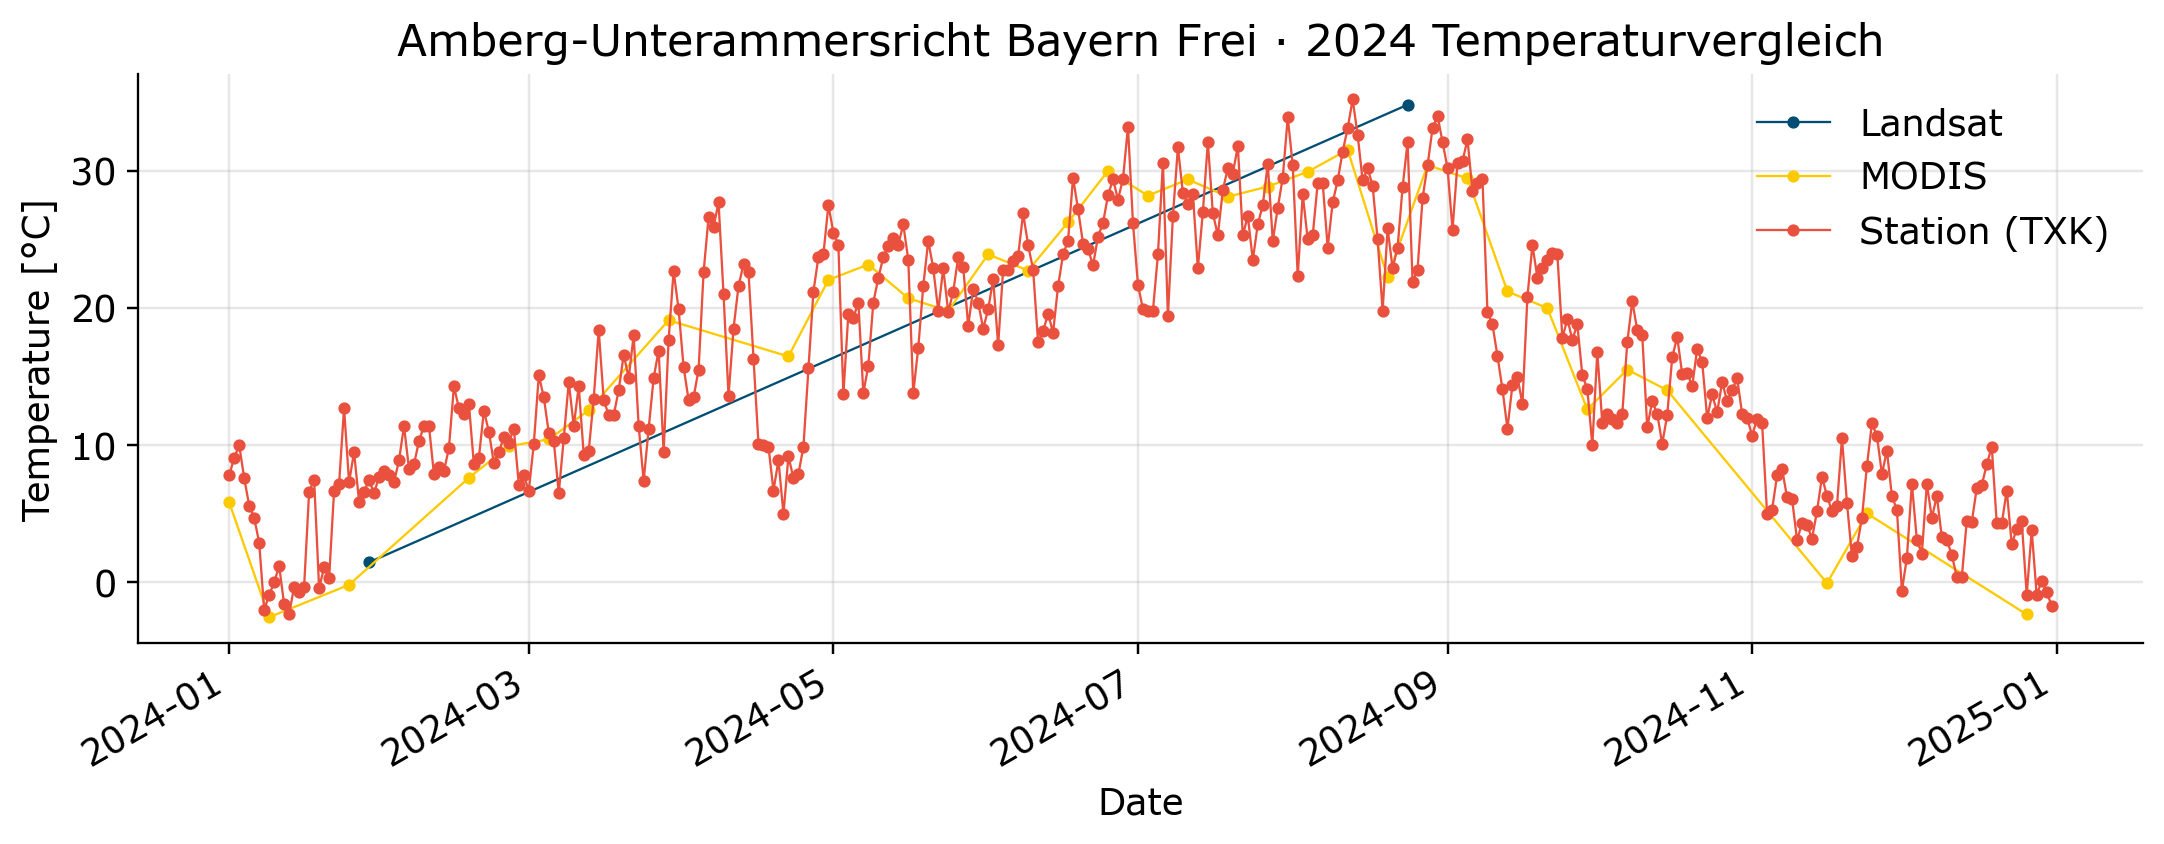

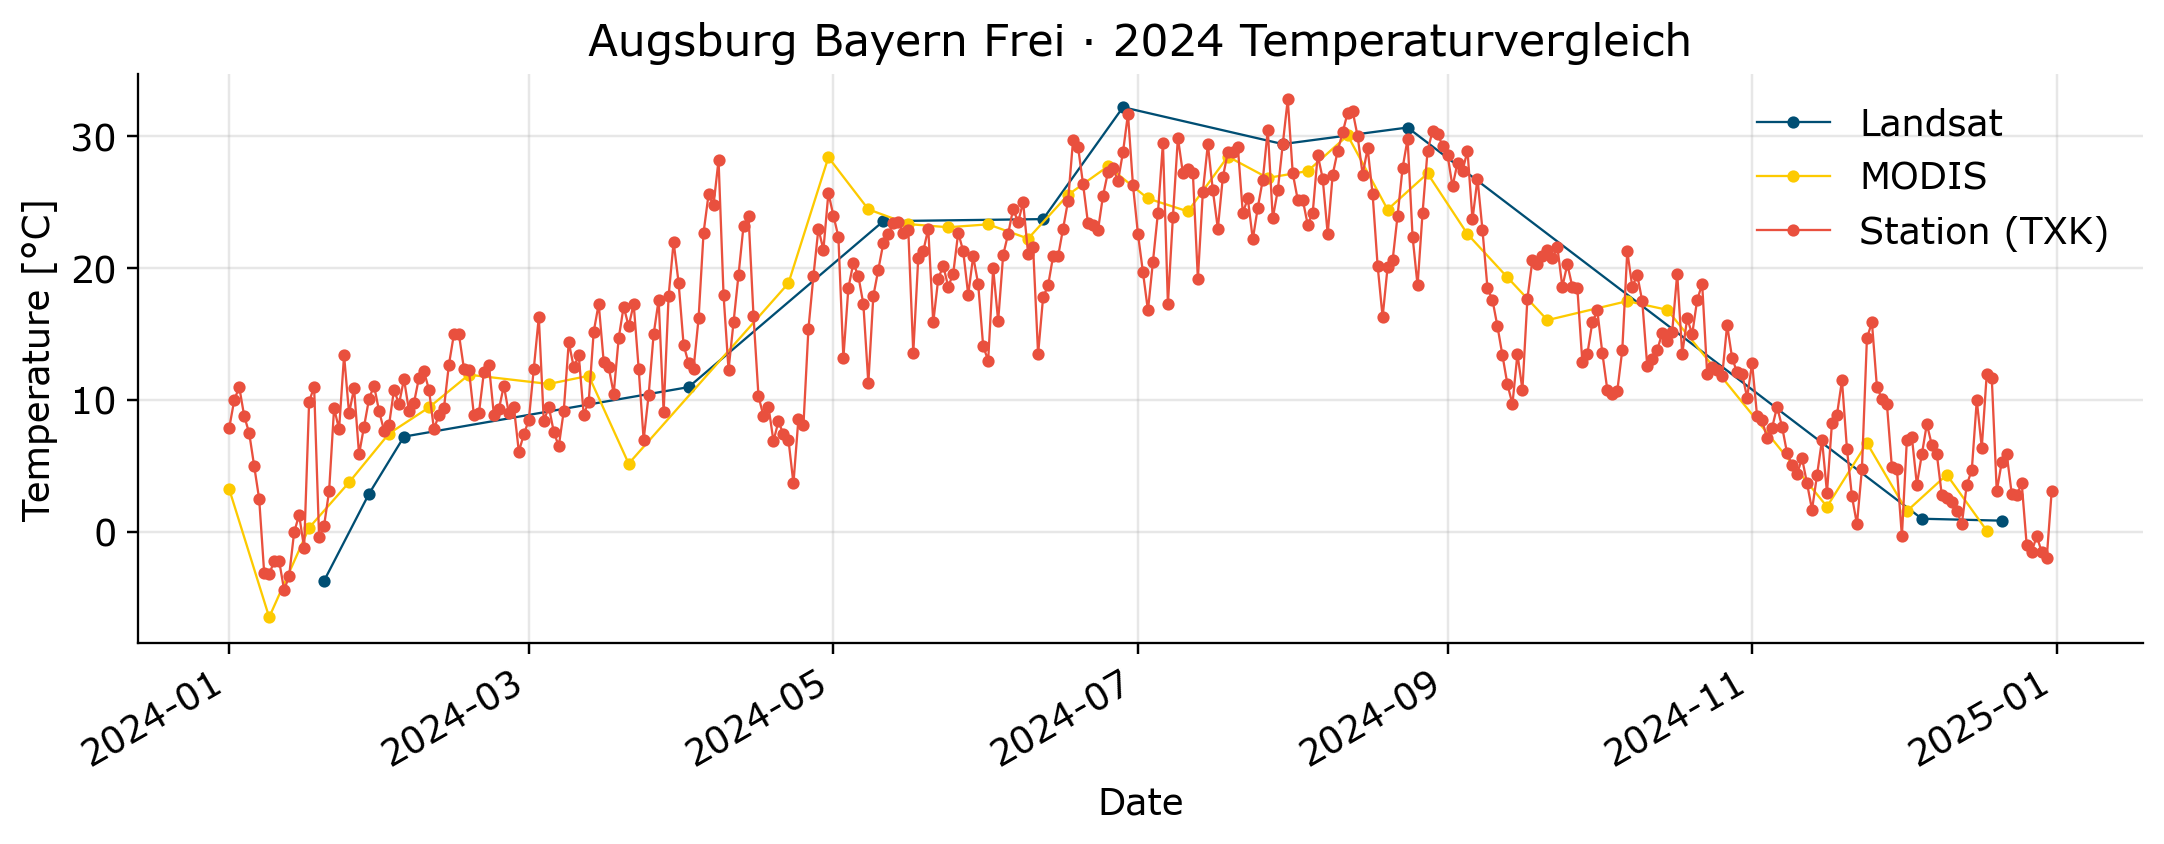

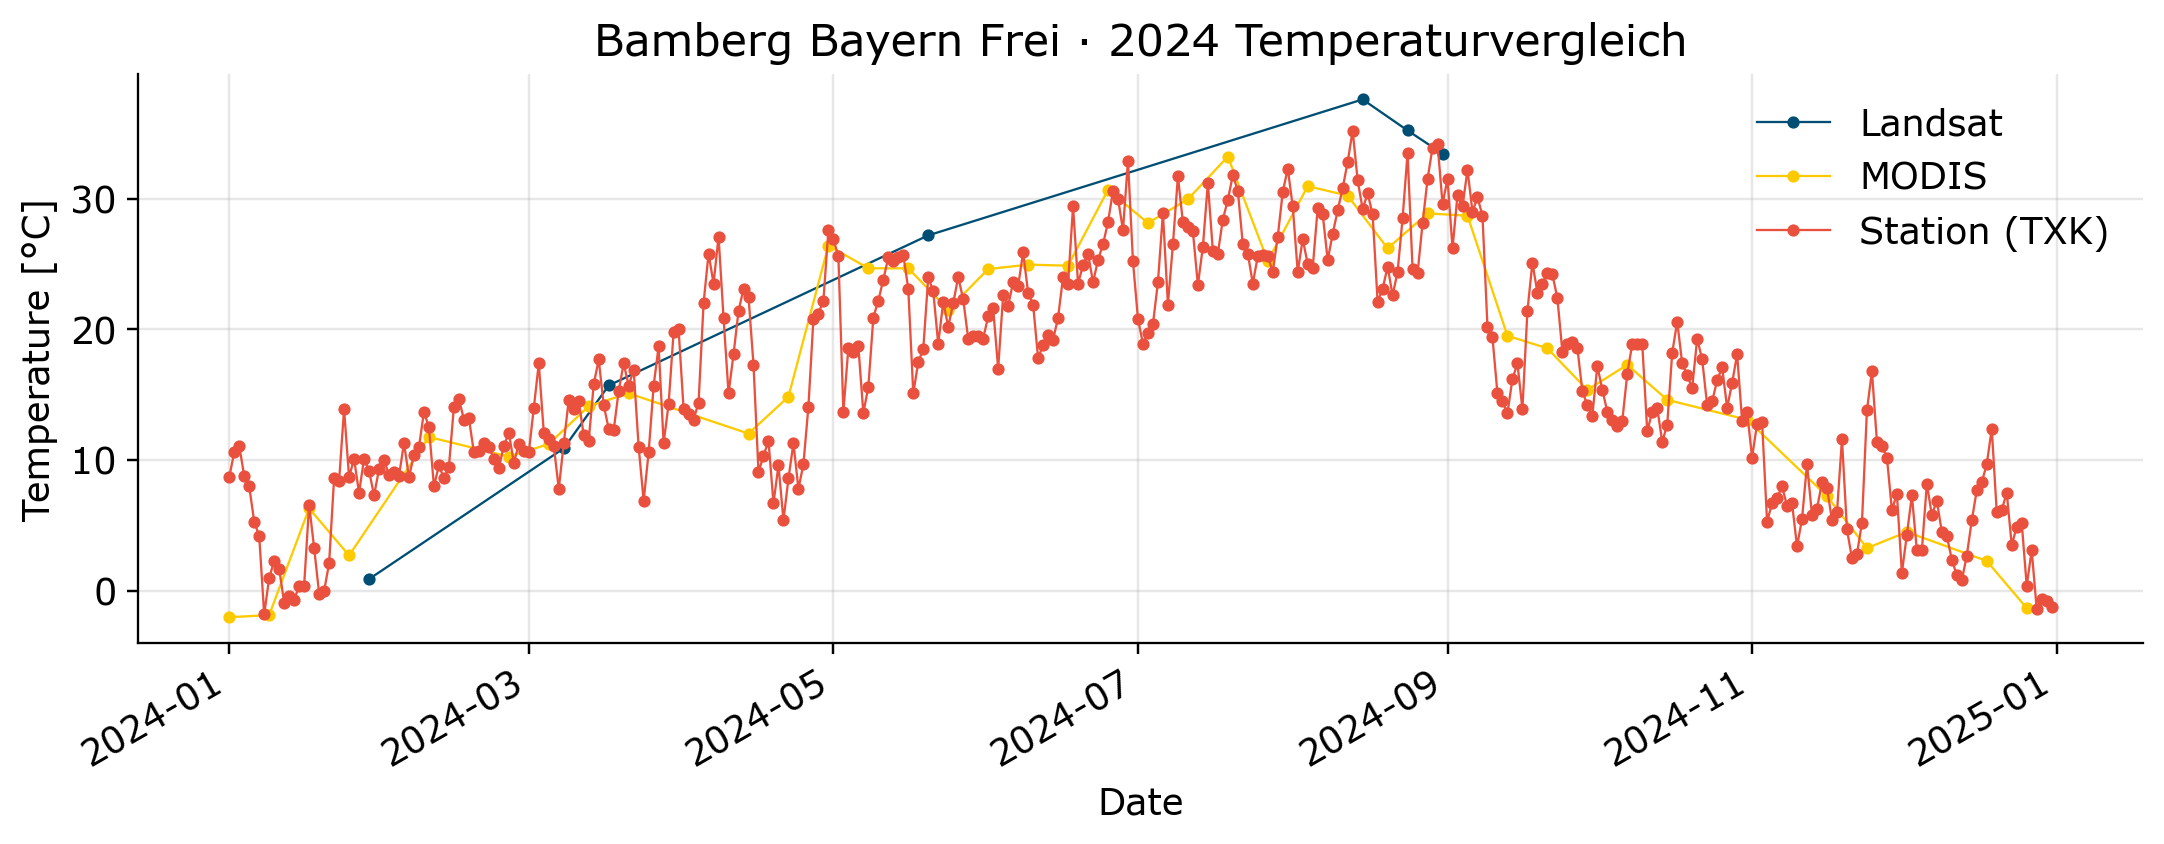

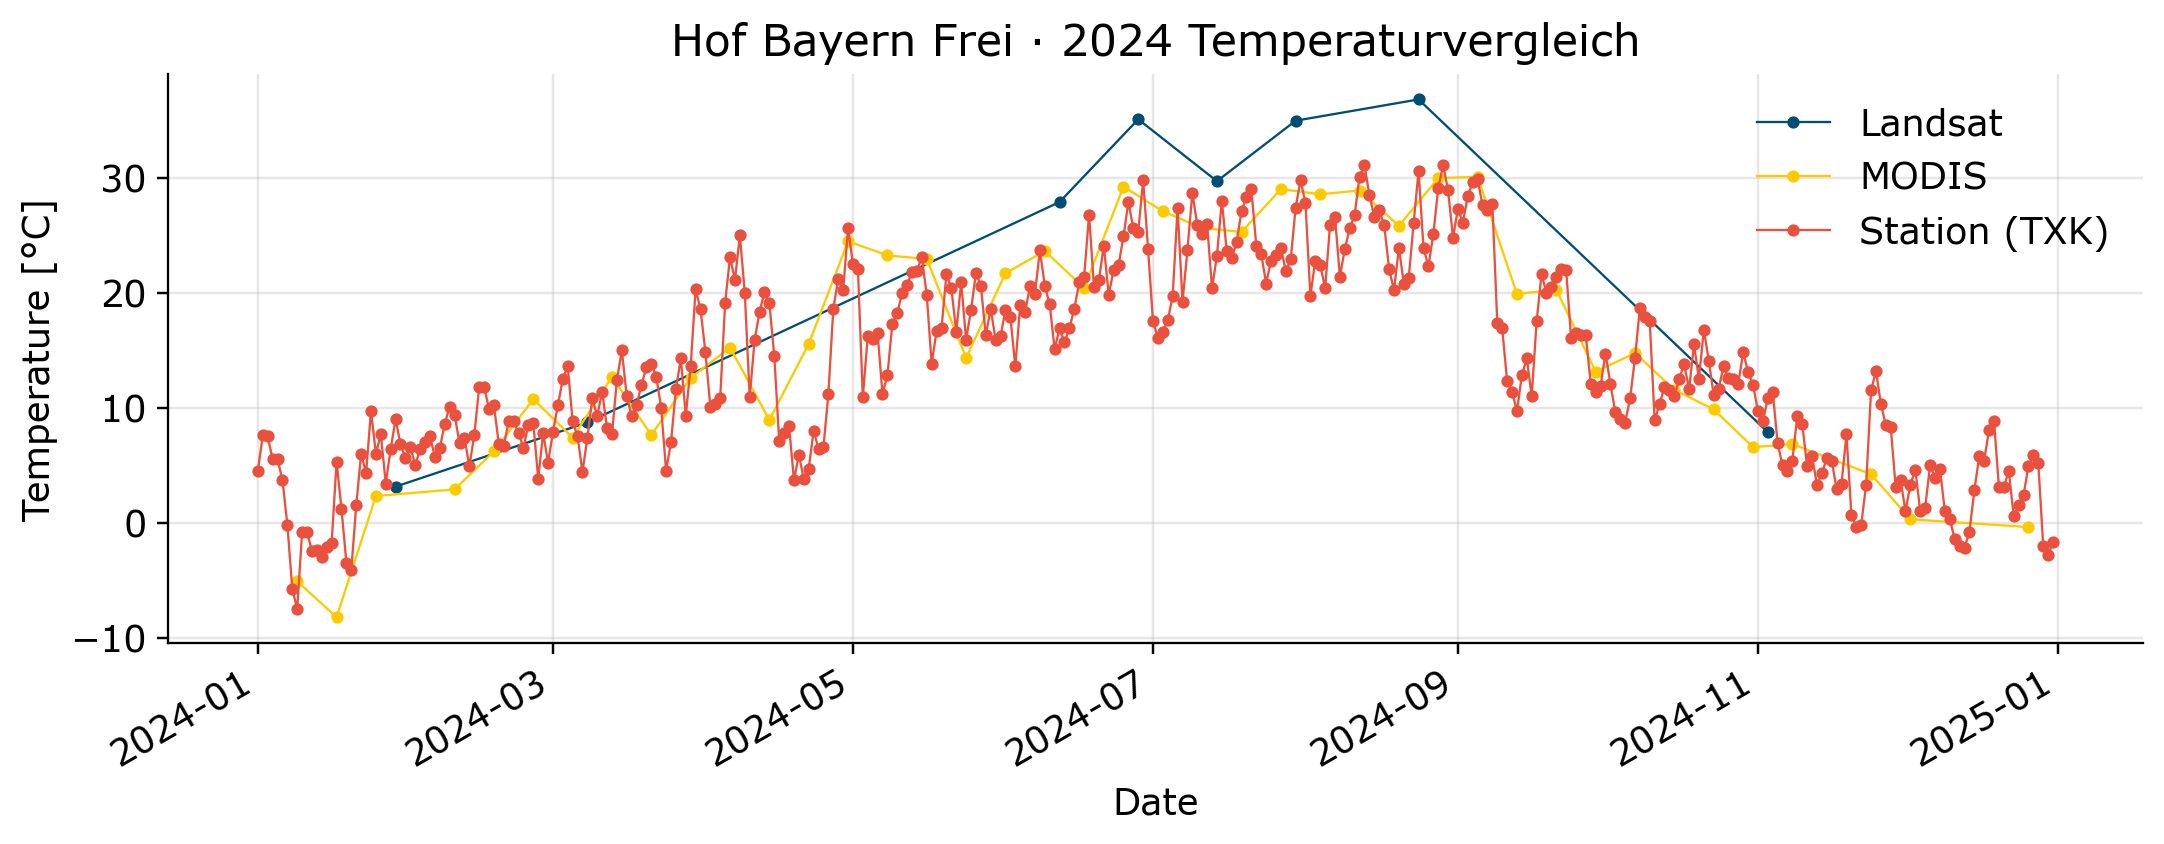

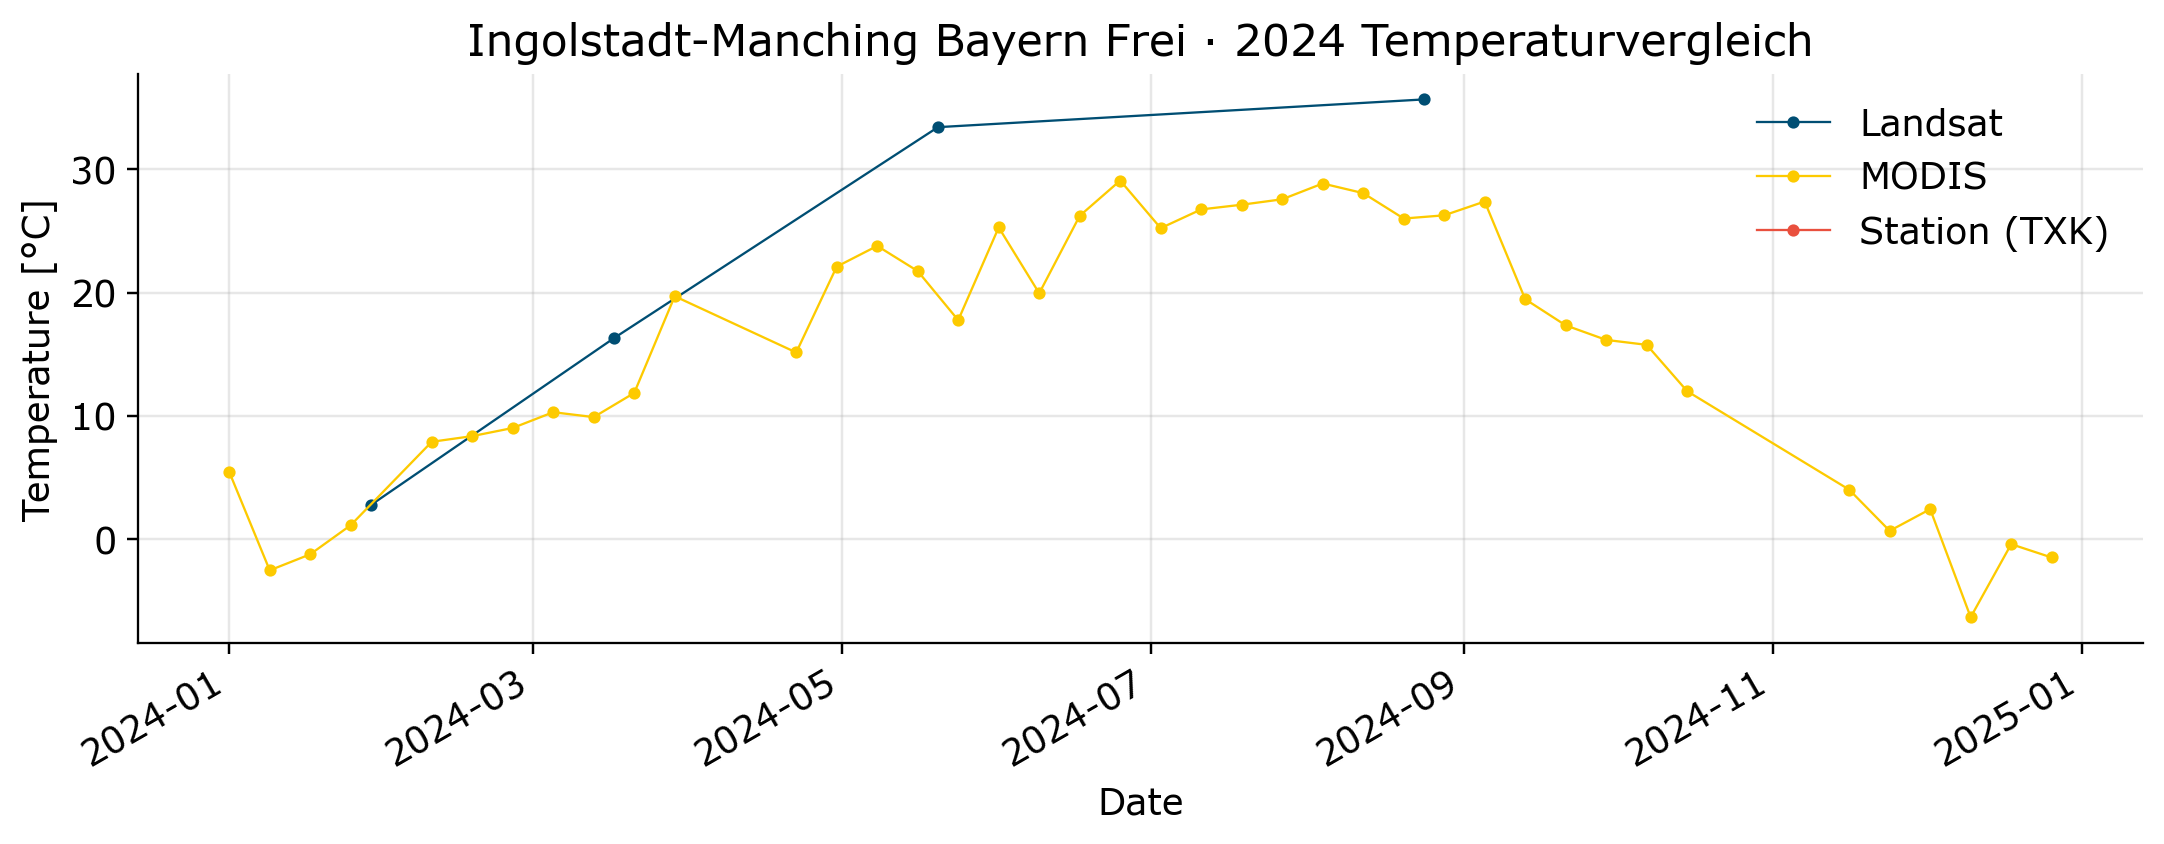

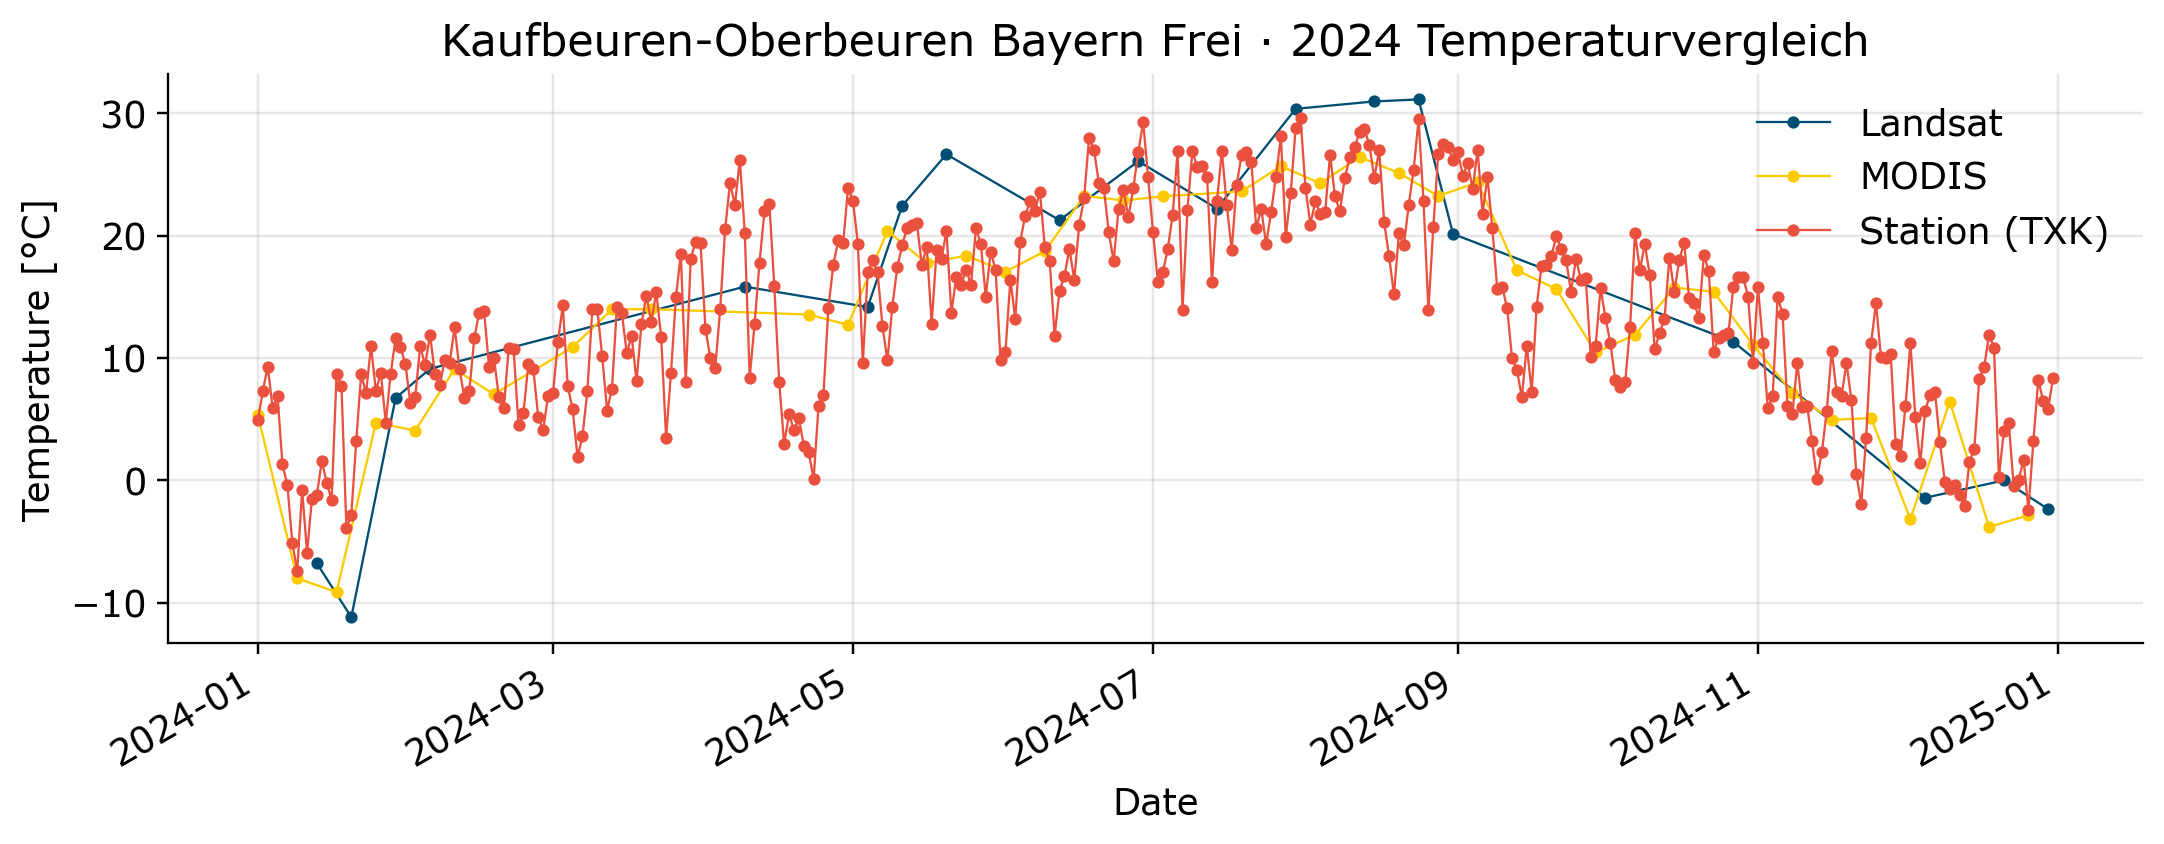

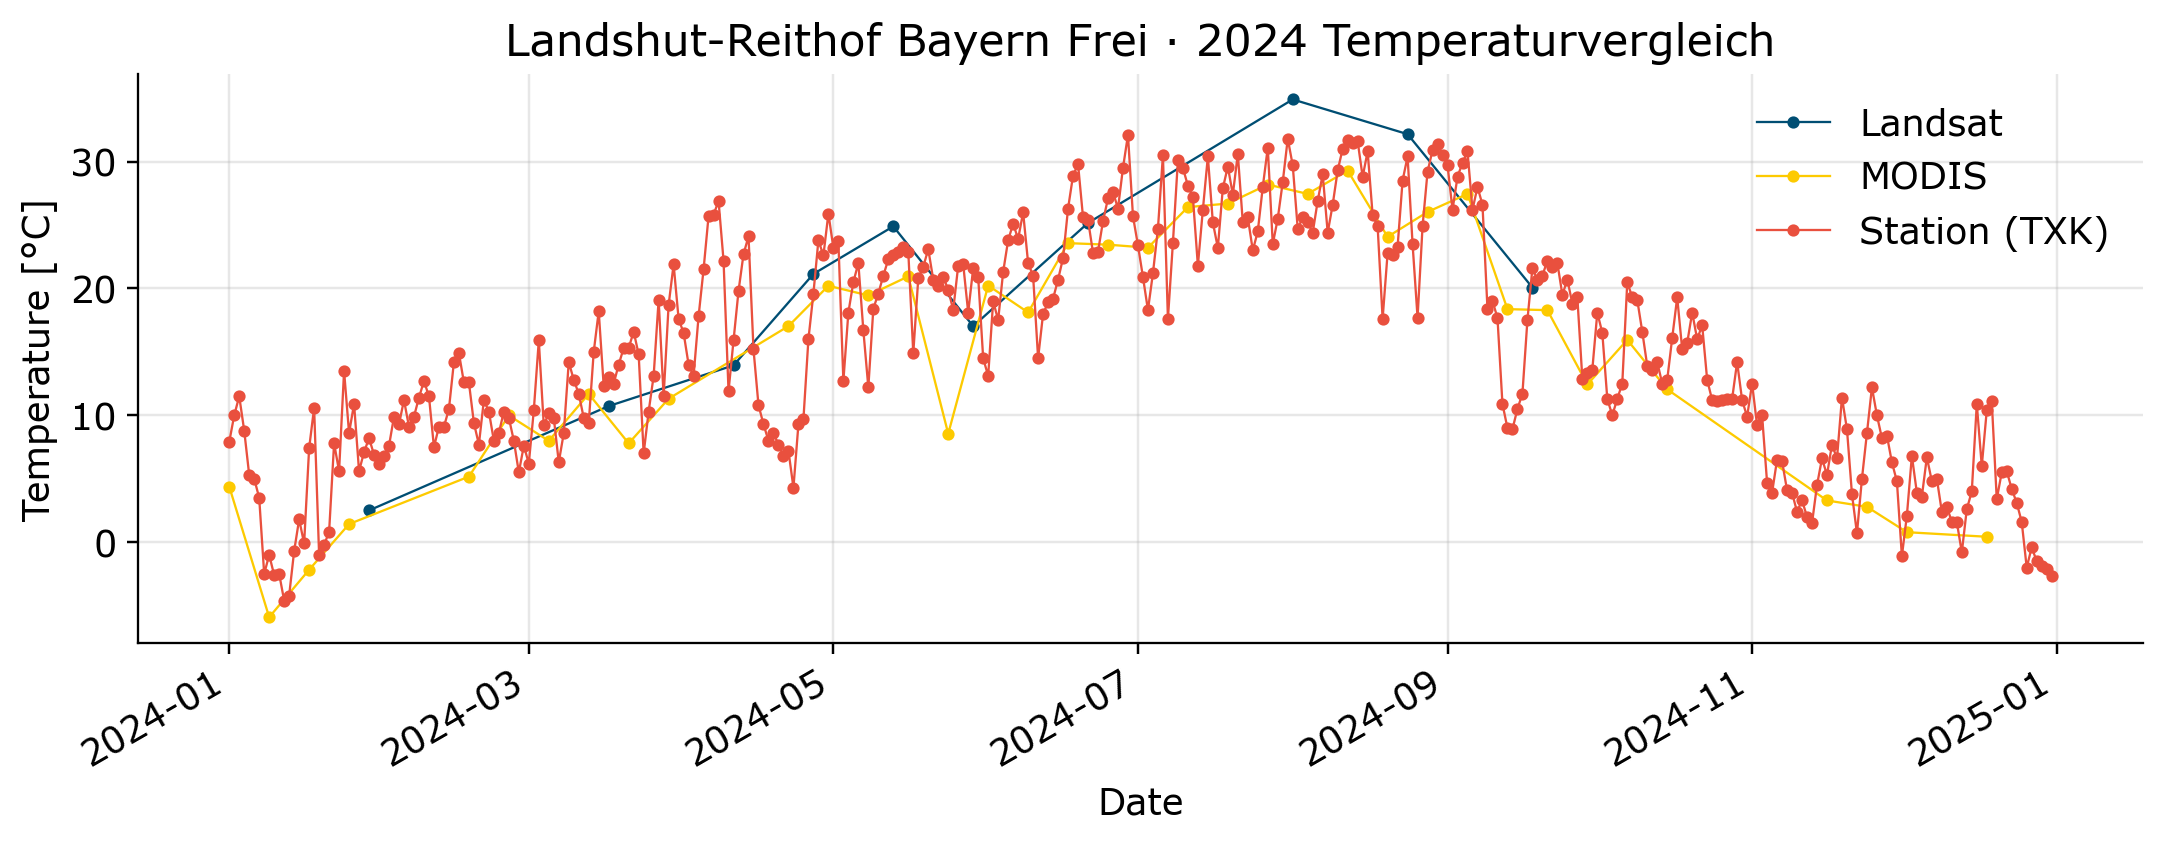

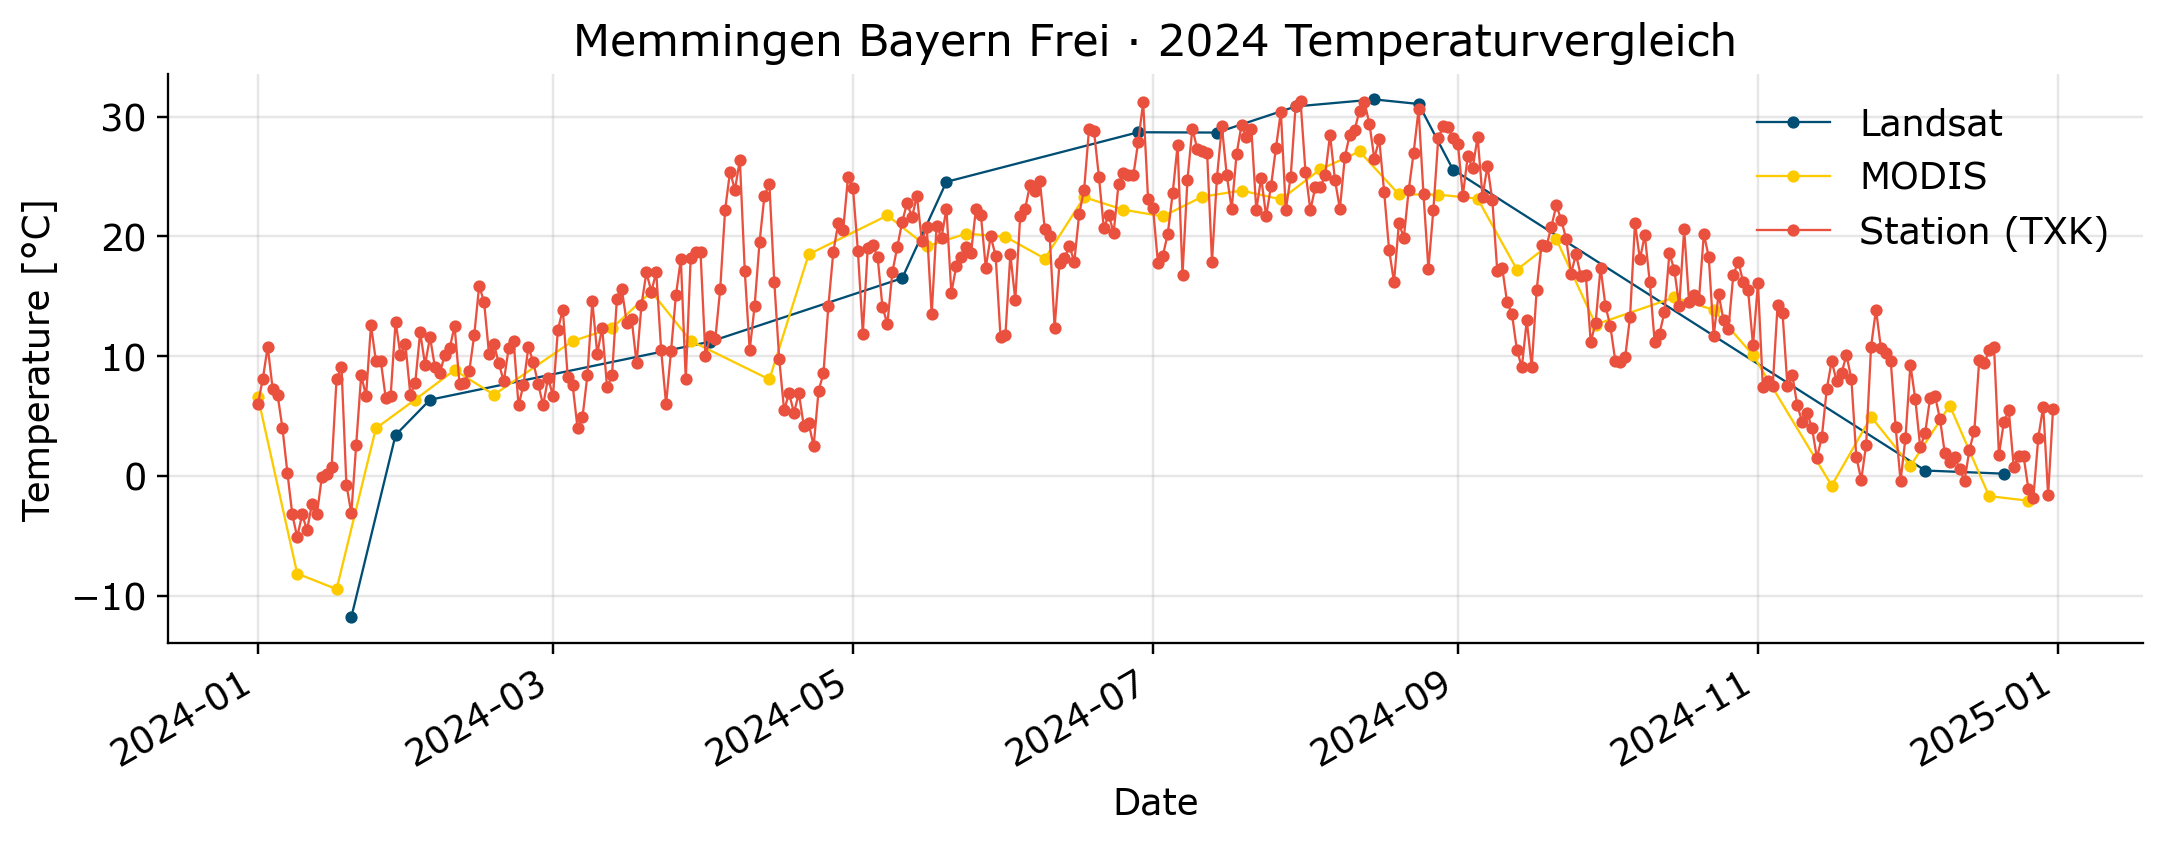

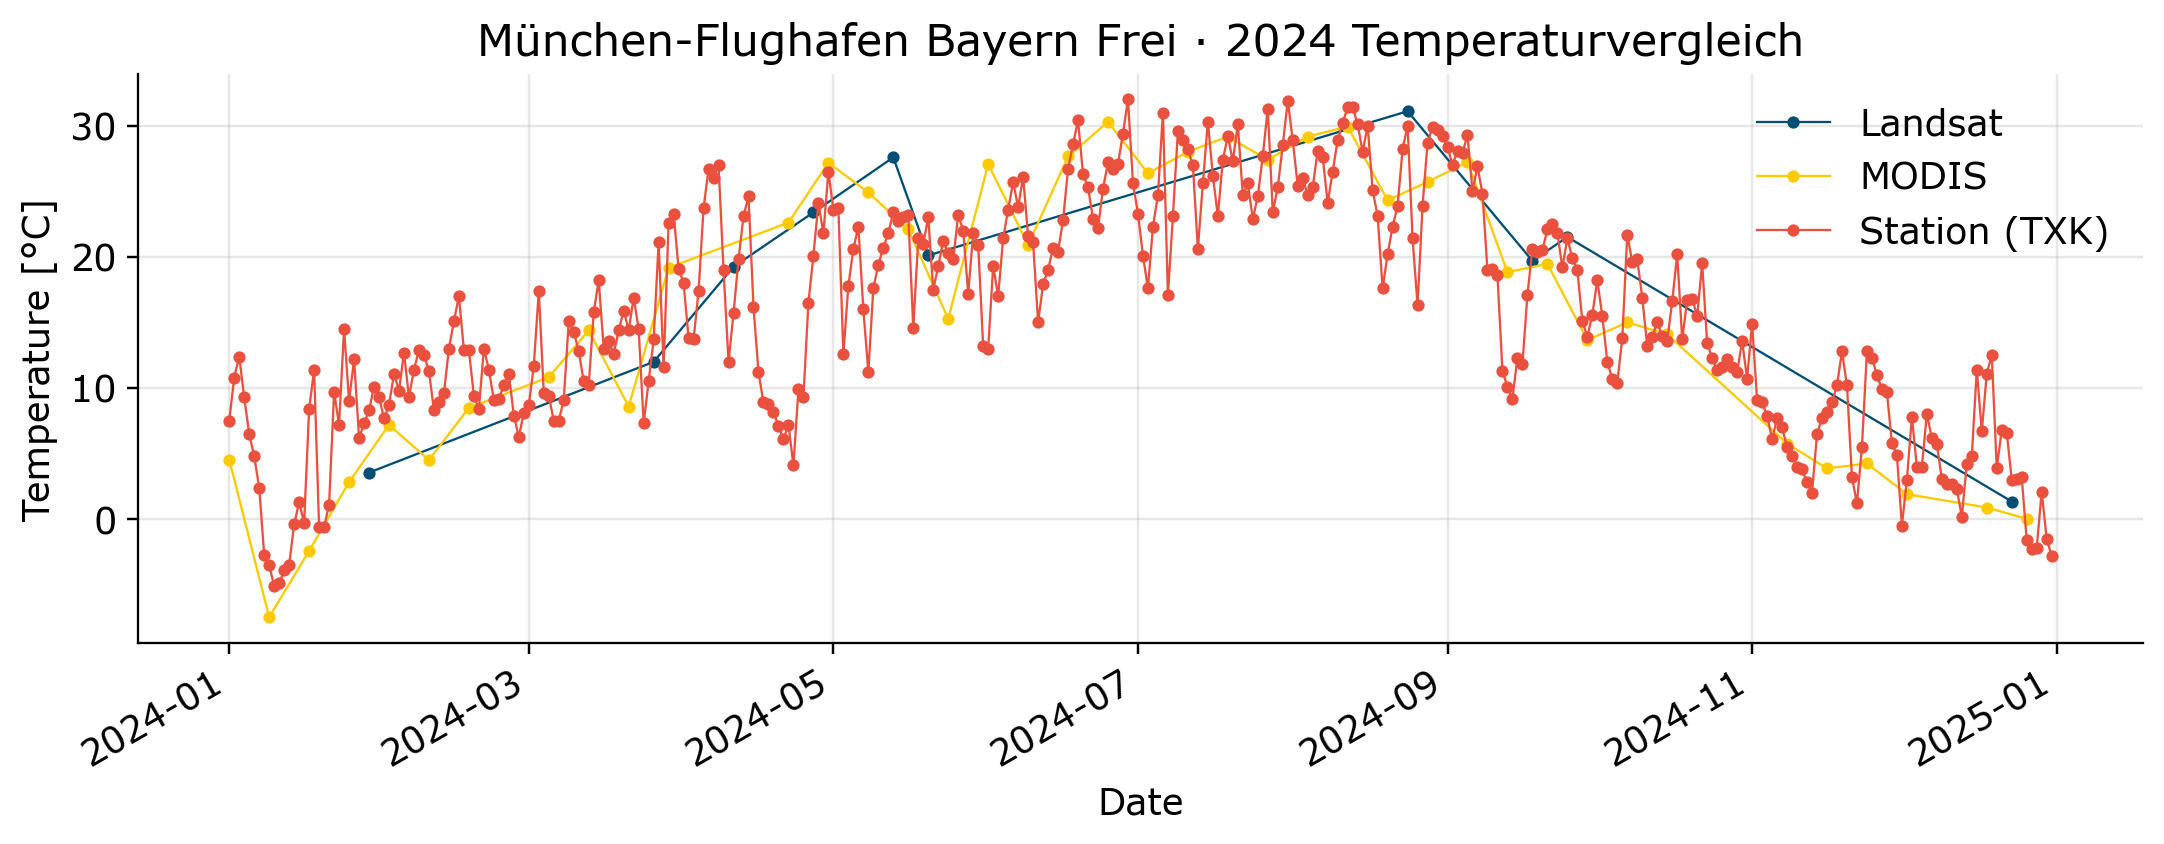

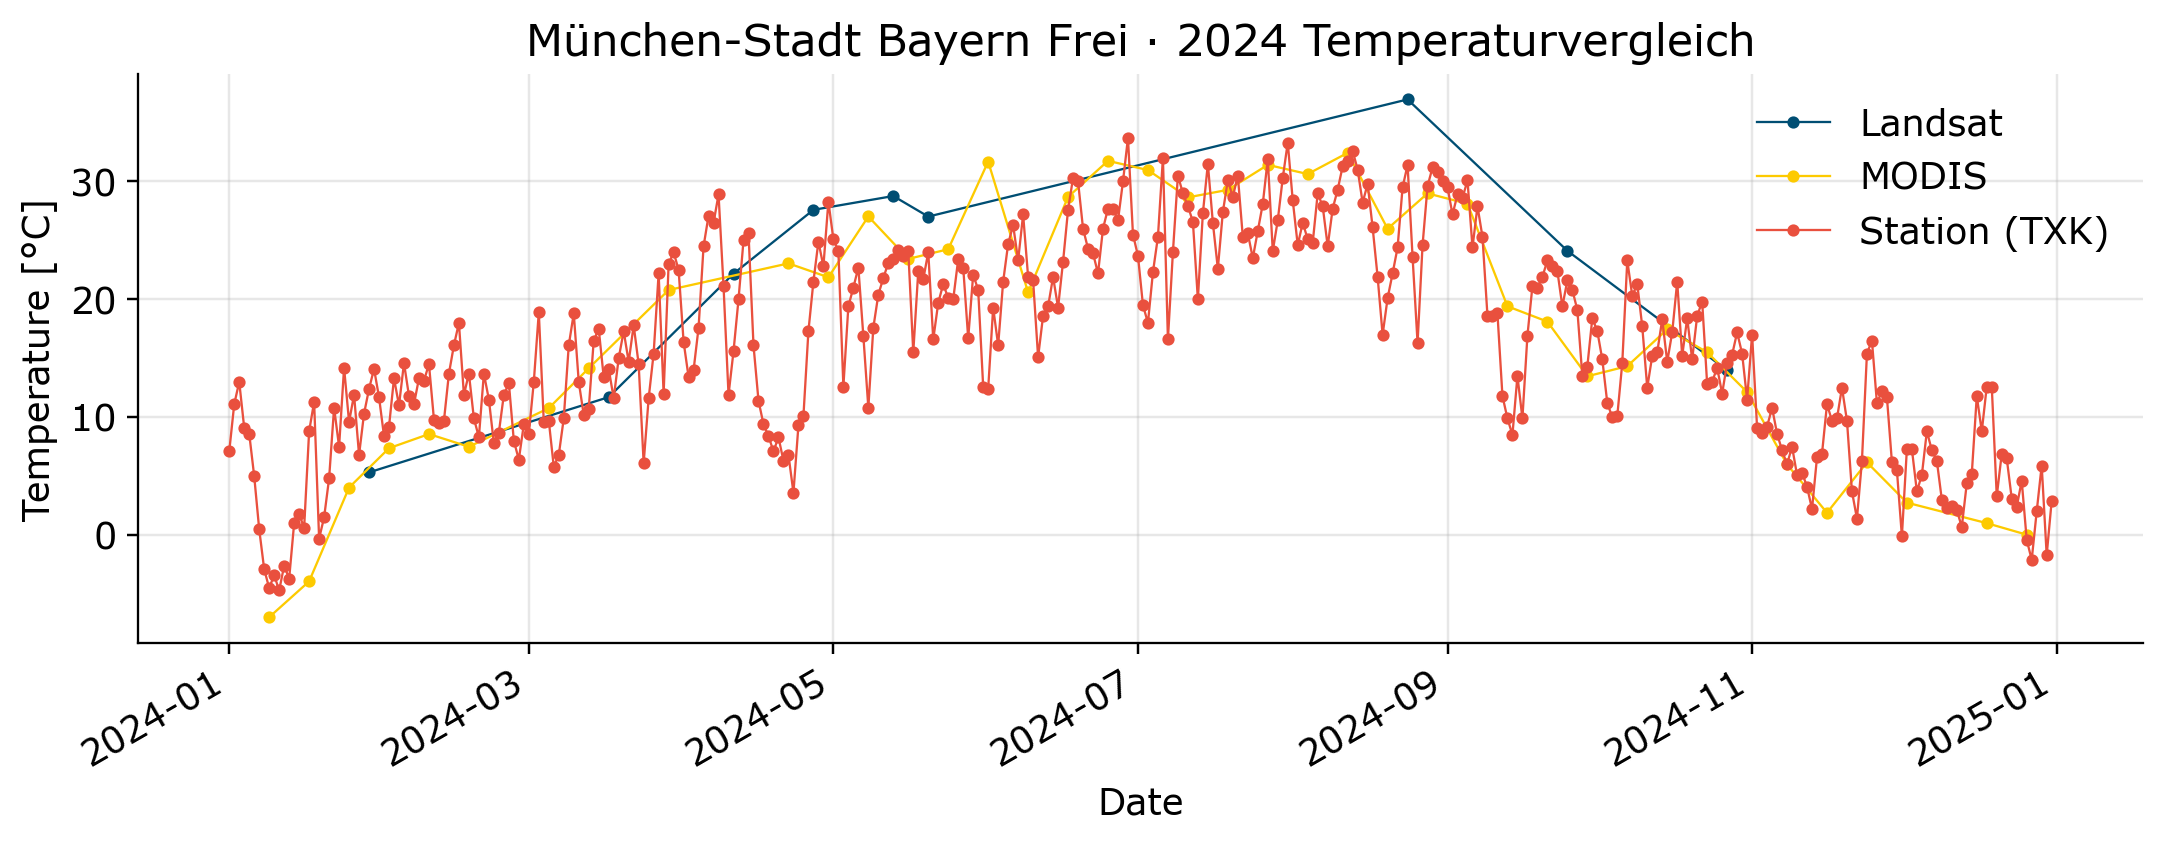

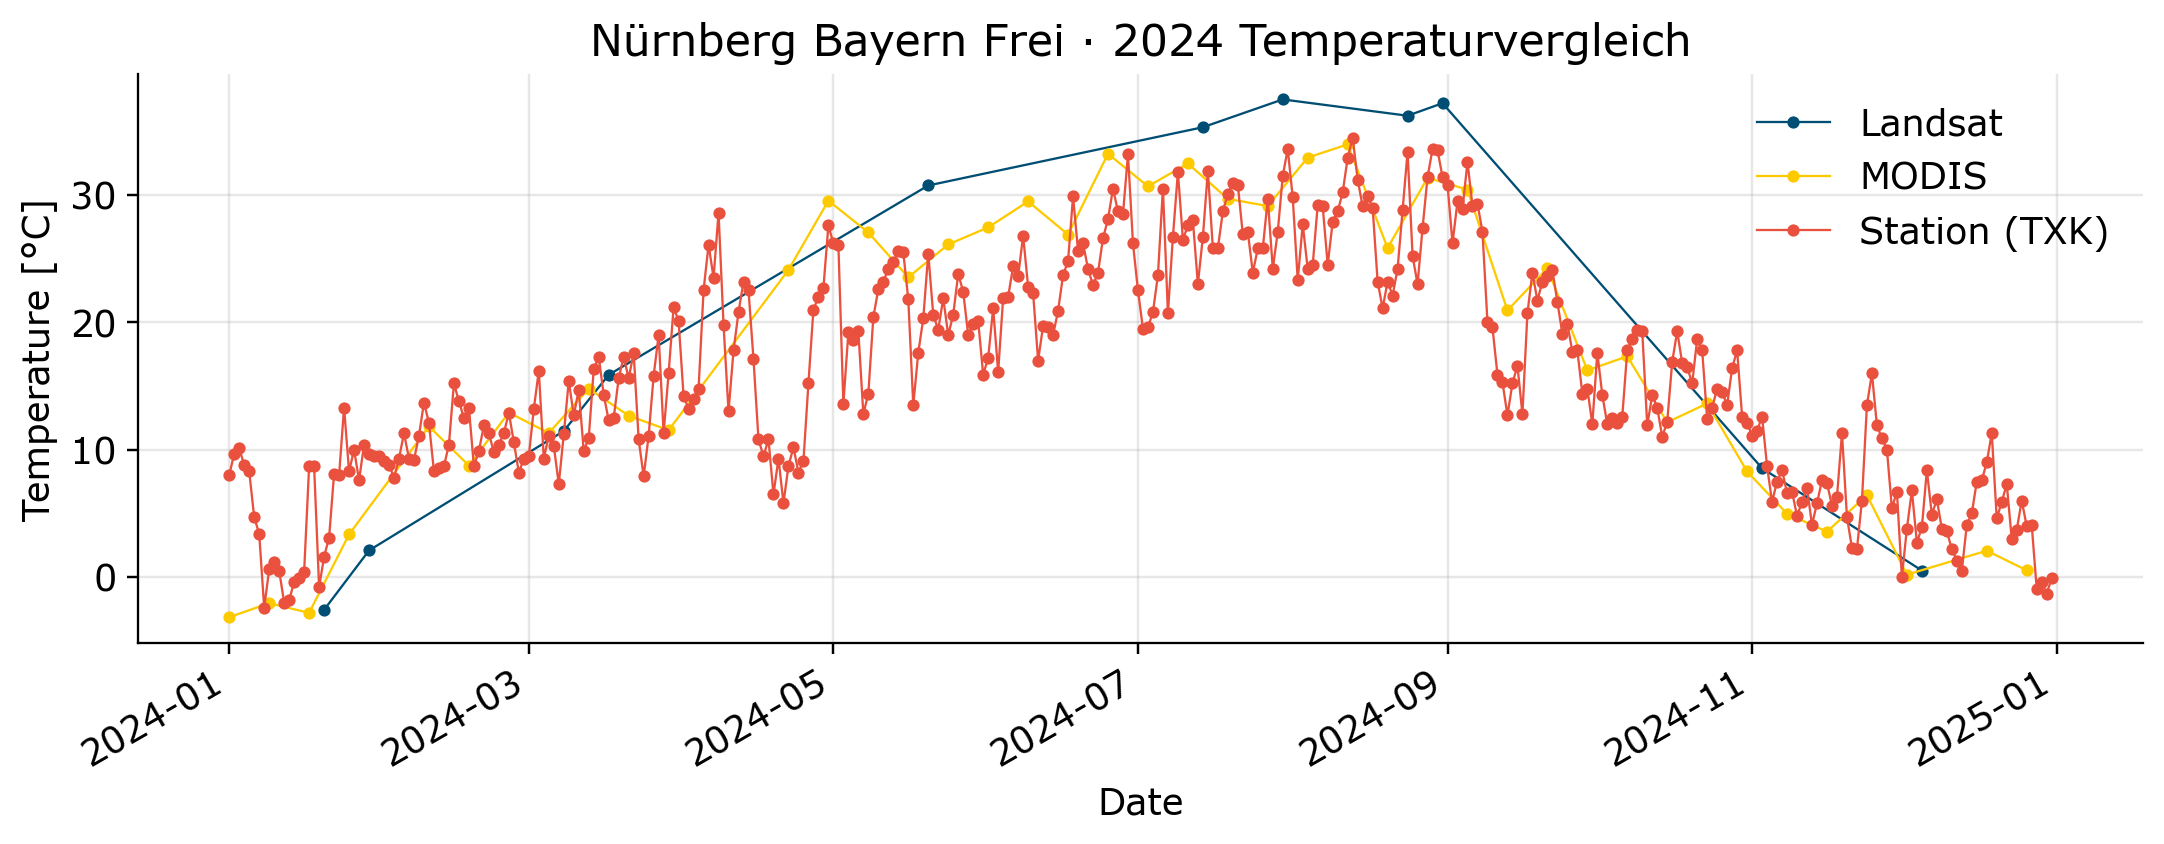

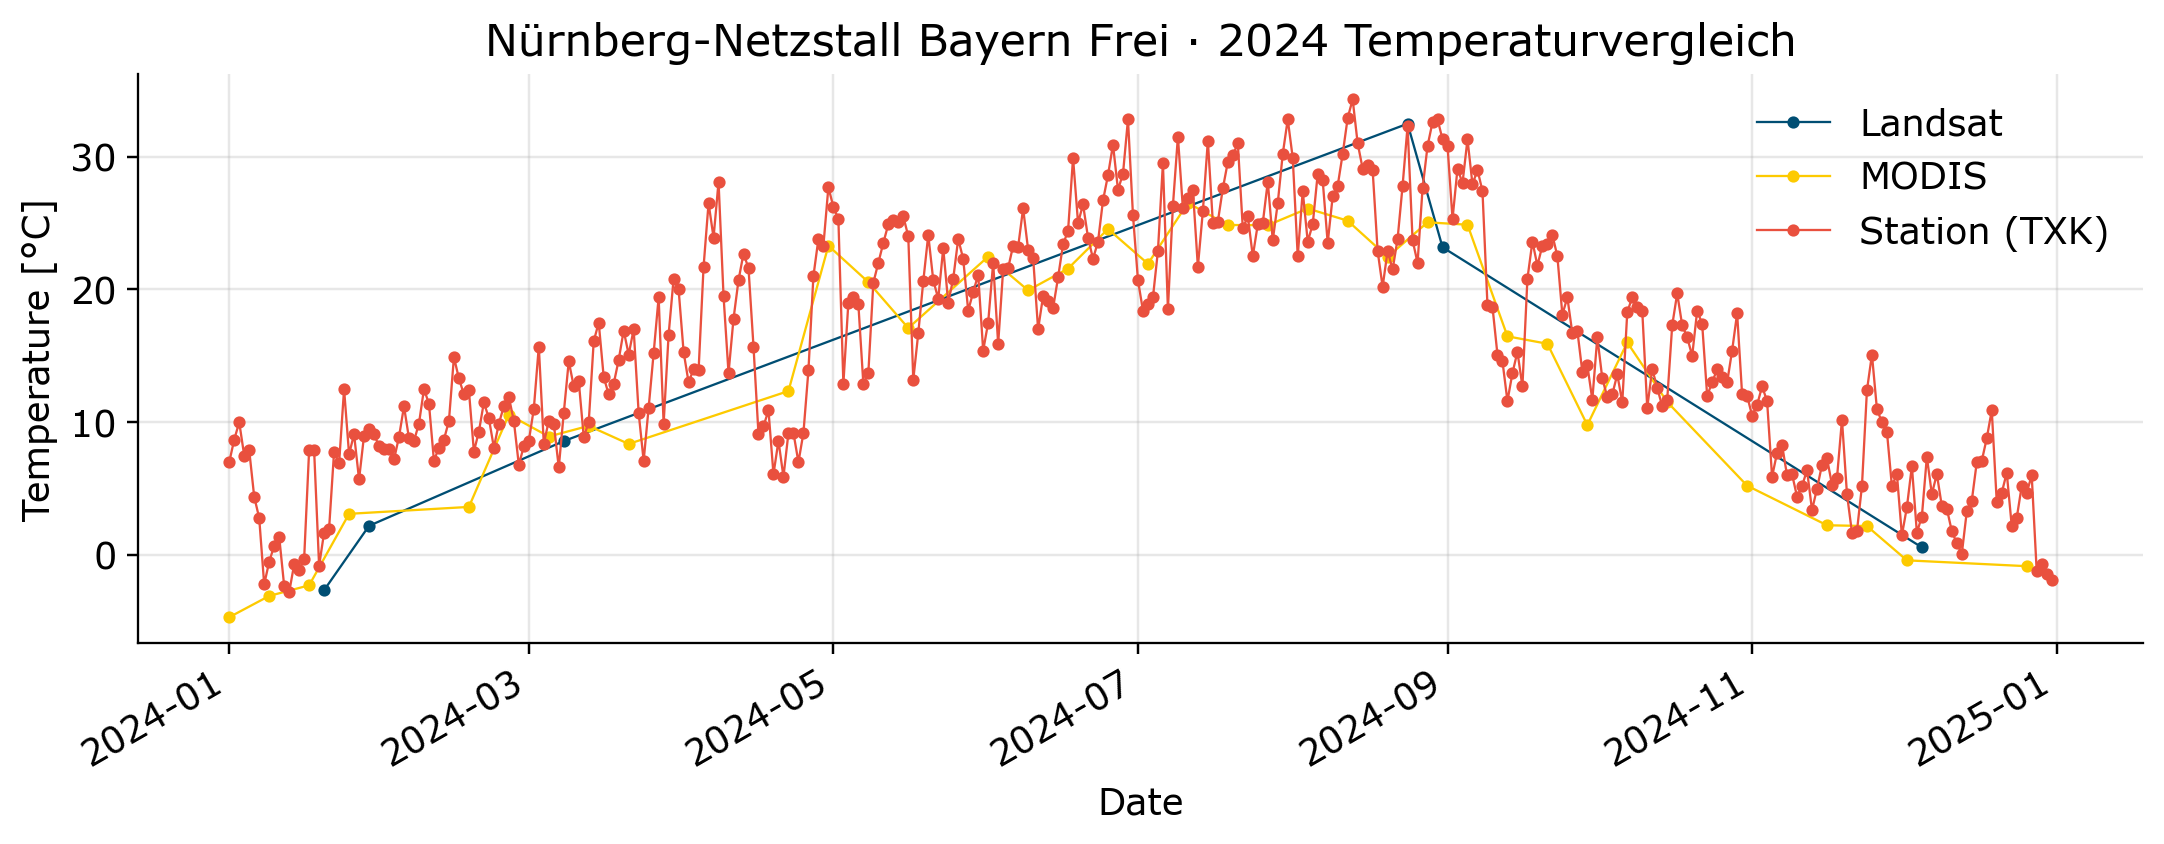

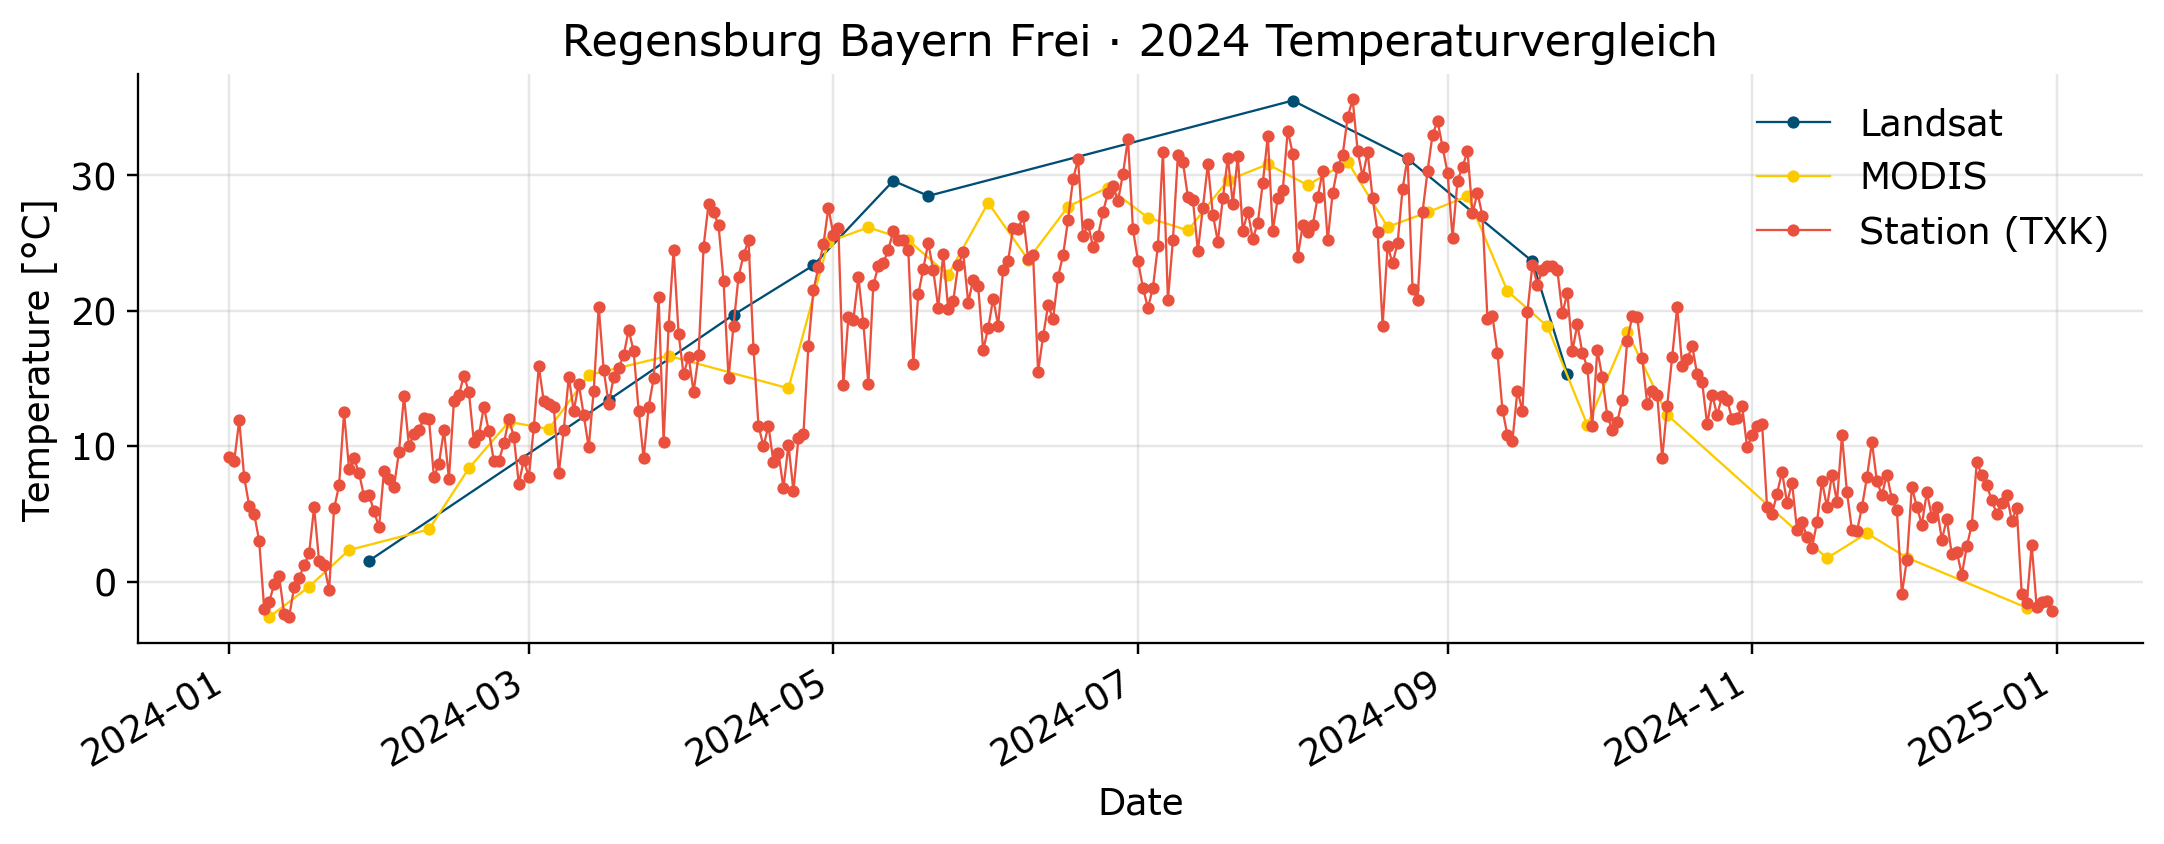

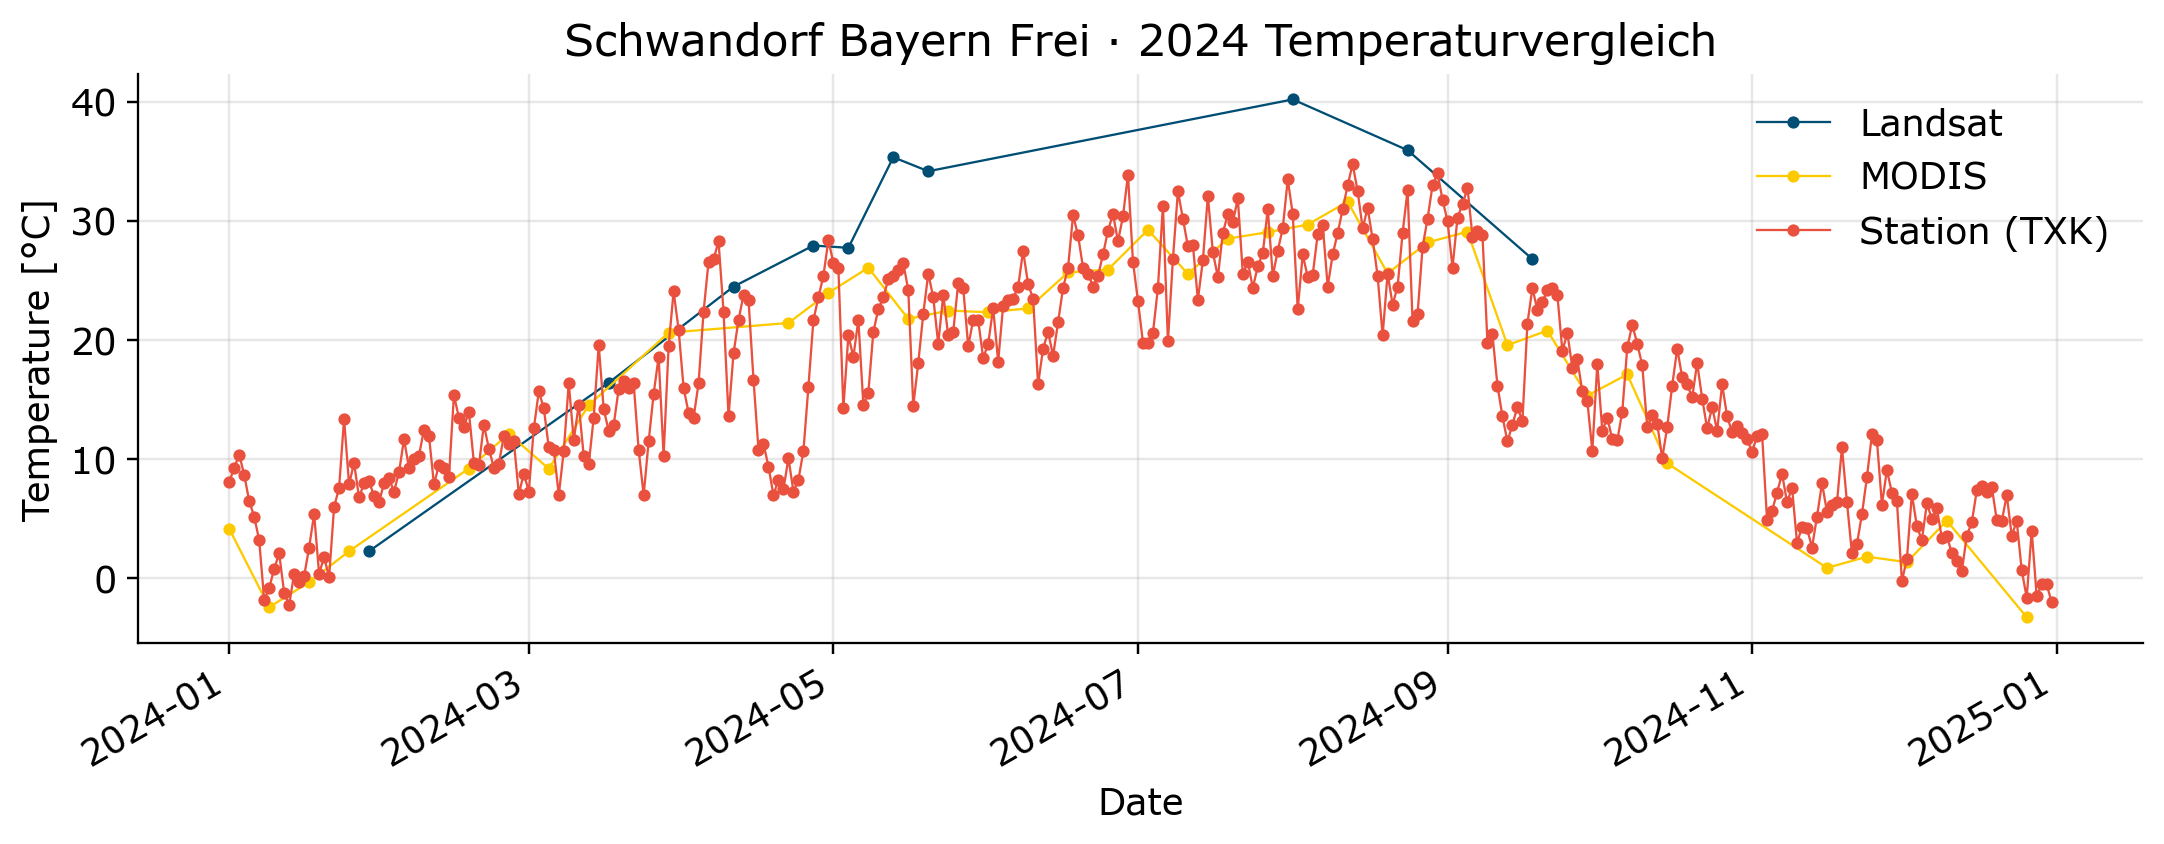

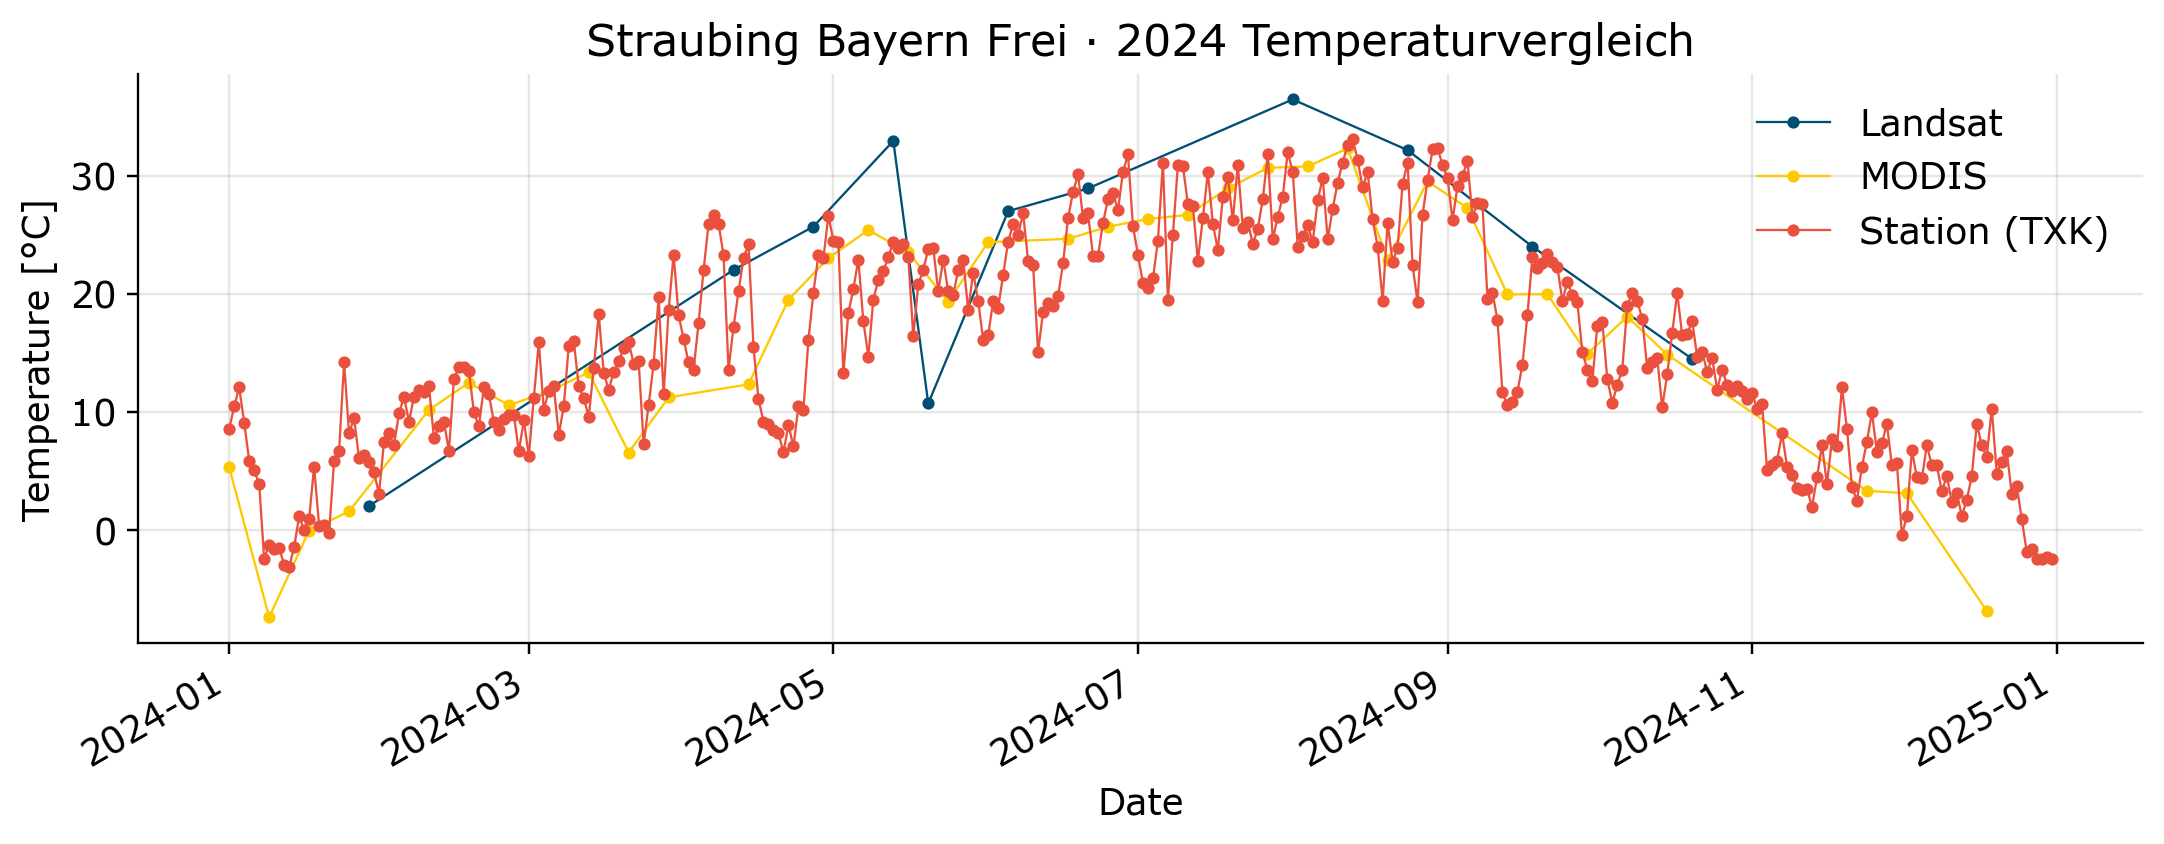

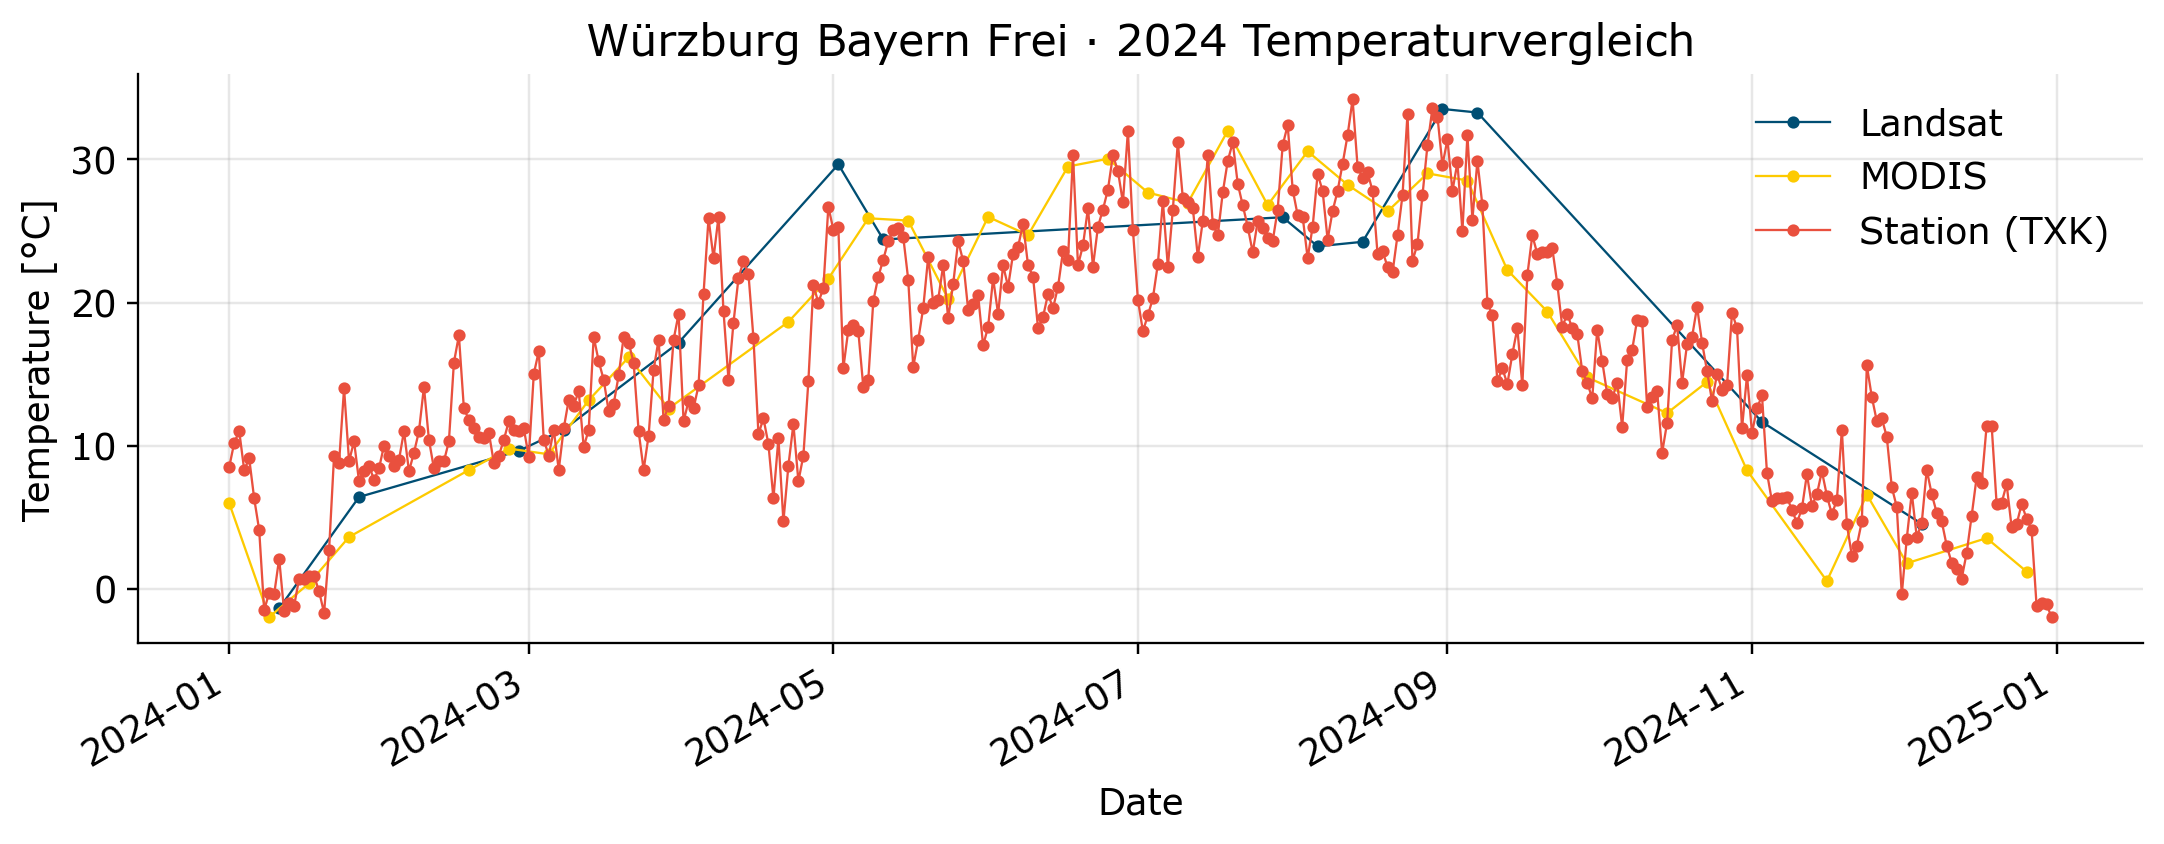

In [48]:
import pandas as pd
import re

CITY_COL = "Name"     # deine Stadtspalte
STATION_TEMP = "TXK"  # oder TXK, TNK …

# ── 1 · Spalte mit Stations-ID im GeoDataFrame robust finden ────────────
pattern = re.compile(r"stations?_?id", flags=re.I)   # case-/underscore-insensitiv
matches = [c for c in gdf_bayern_top50_2025.columns if pattern.fullmatch(c)]
if not matches:
    raise KeyError("Keine Stations-ID-Spalte im GeoDataFrame gefunden.")
gdf_station_col = matches[0]                         # z. B. "Stations_ID"

# ── 2 · Typ vereinheitlichen: beidseitig zu int ─────────────────────────
gdf_bayern_top50_2025["STATIONS_ID"] = (
    gdf_bayern_top50_2025[gdf_station_col]
    .astype(str).str.lstrip("0")       # führende Nullen abwerfen
    .astype(int)
)

stations_df["STATIONS_ID"] = stations_df["STATIONS_ID"].astype(int)

# ── 3 · Lookup-Tabelle (Name ↔ Station) erstellen ──────────────────────
station_lookup = (
    gdf_bayern_top50_2025[[CITY_COL, "STATIONS_ID"]]
    .dropna(subset=["STATIONS_ID"])
    .drop_duplicates()
)

# ── 4 · Stations-Tageswerte an die Städte anhängen ─────────────────────
stations_named = (
    stations_df.merge(station_lookup, on="STATIONS_ID", how="inner")
               .loc[:, [CITY_COL, "date", STATION_TEMP]]
)

stations_daily = (
    stations_named            # falls mehrere Messpunkte je Stadt
    .groupby([CITY_COL, "date"], as_index=False)
    .agg({STATION_TEMP: "mean"})
)

# ── 5 · Landsat täglich mitteln & MODIS anhängen (aus df_all) ──────────
landsat_daily = (
    df_all[df_all["sensor"] == "Landsat"]
    .groupby([CITY_COL, "date"], as_index=False)
    .agg({"LST": "mean"})
    .assign(sensor="Landsat")
)

modis = df_all[df_all["sensor"] == "MODIS"][ [CITY_COL, "date", "LST", "sensor"] ]
lst_plot = pd.concat([landsat_daily, modis], ignore_index=True)

# ── 6 · Plot je Stadt ──────────────────────────────────────────────────


for city in sorted(lst_plot[CITY_COL].unique()):
    fig, ax = plt.subplots(figsize=(10, 4))

    # LST-Kurven
    for sensor, ss in lst_plot[lst_plot[CITY_COL] == city].groupby("sensor"):
        ss = ss.sort_values("date")
        ax.plot(ss["date"], ss["LST"],
                marker=".", linestyle="-", label=sensor)

    # Stations-Temperatur
    ss_stn = stations_daily[stations_daily[CITY_COL] == city]
    if not ss_stn.empty:
        ss_stn = ss_stn.sort_values("date")
        ax.plot(ss_stn["date"], ss_stn[STATION_TEMP],
                marker=".", linestyle="-", label=f"Station ({STATION_TEMP})")

    ax.set_title(f"{city} · 2024 Temperaturvergleich")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature [°C]")
    ax.grid(True, alpha=.3)
    ax.legend()
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


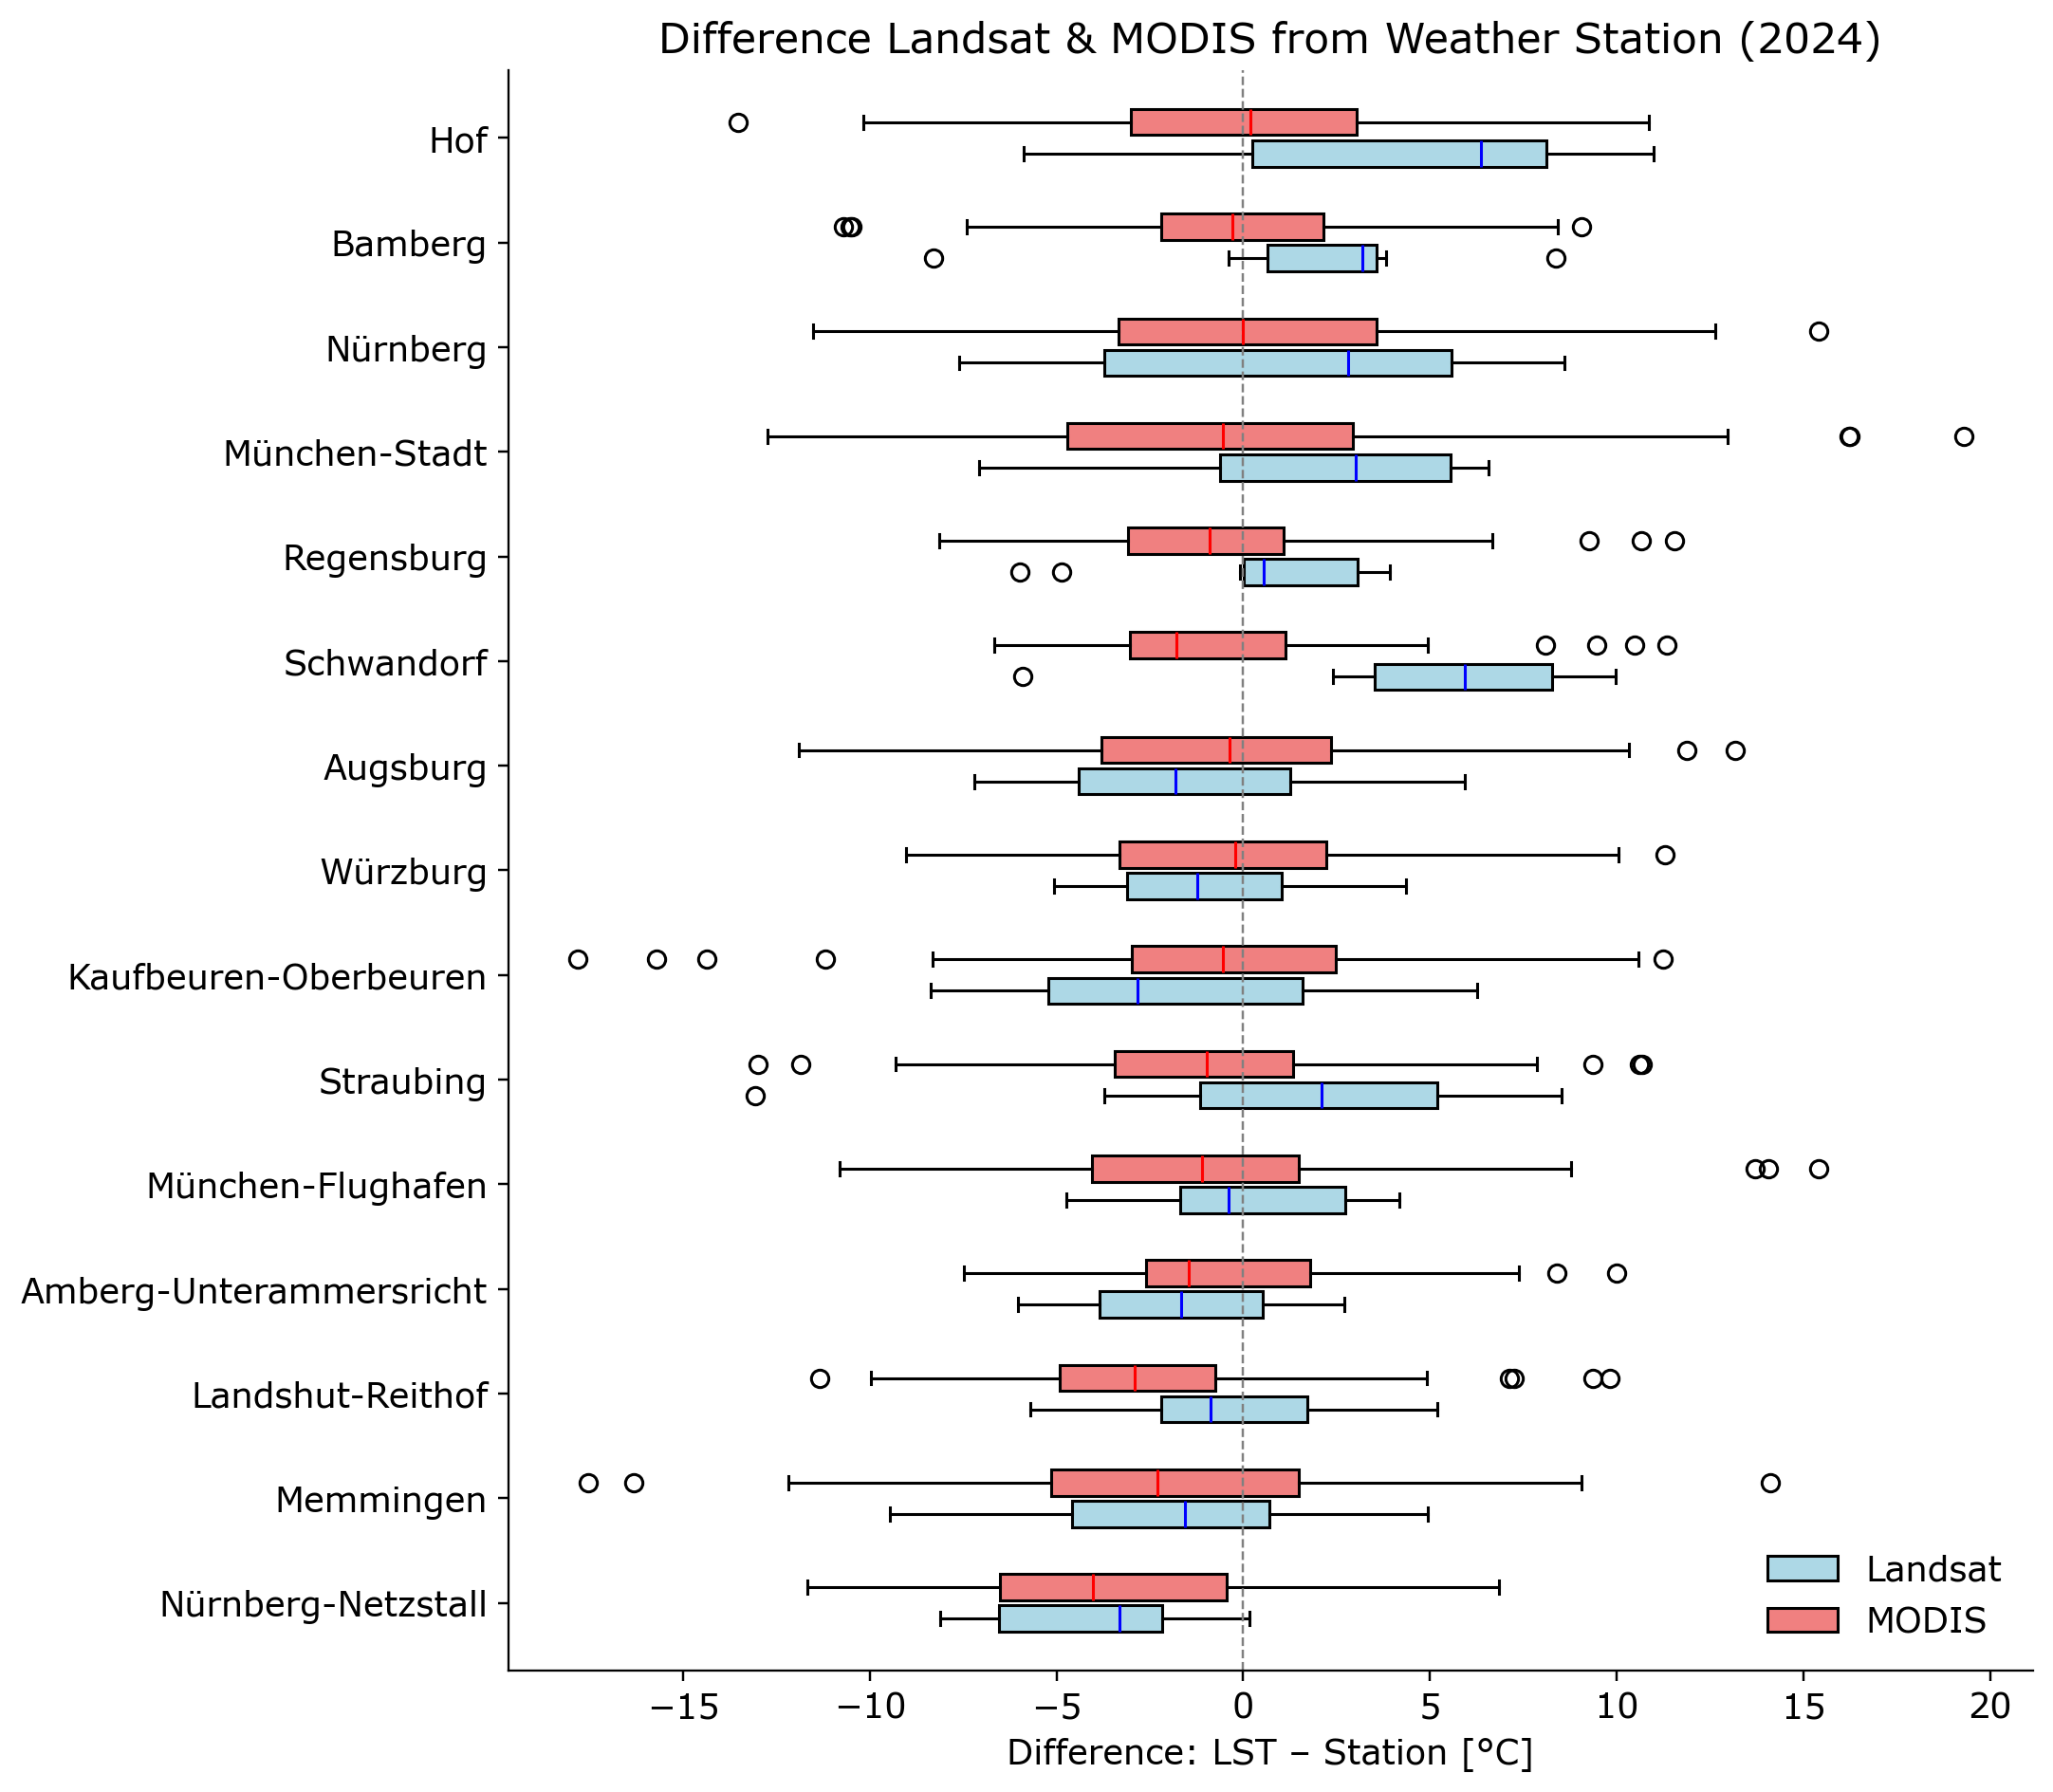

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ── KONFIGURATION ─────────────────────────────────────────────────────
CITY_COL      = "Name"   # Spalte mit Städtenamen
STATION_TEMP  = "TXK"    # Stations-Temperaturspalte
YEAR_LABEL    = "2024"   # Titel-Jahr
# ──────────────────────────────────────────────────────────────────────

# === 1 · Landsat täglich mitteln, MODIS unverändert ===
landsat_daily = (
    df_all[df_all["sensor"] == "Landsat"]
    .groupby([CITY_COL, "date"], as_index=False)
    .agg({"LST": "mean"})
    .assign(sensor="Landsat")
)
modis = df_all[df_all["sensor"] == "MODIS"][[CITY_COL, "date", "LST", "sensor"]]

lst_plot = pd.concat([landsat_daily, modis], ignore_index=True)

# === 2 · Stations-Werte anhängen und Differenz berechnen ===
df_diff = lst_plot.merge(
    stations_daily,                # enthält Spalten [Name, date, TMK]
    on=[CITY_COL, "date"],
    how="inner"
)
df_diff["diff"] = df_diff["LST"] - df_diff[STATION_TEMP]

# === 3 · Städte nach Median-Abweichung sortieren ===
order_raw = (df_diff.groupby(CITY_COL)["diff"]
                      .median()
                      .sort_values()
                      .index
                      .tolist())

# === 4 · Stadtname bereinigen (z. B. "Bamberg Bayern Frei" → "Bamberg") ===
def clean_city(name):
    return name.replace("Bayern Frei", "").strip()

order_cleaned = [clean_city(c) for c in order_raw]

# === 5 · Abweichungen je Stadt & Sensor sammeln ===
data_ls = [df_diff[
    (df_diff[CITY_COL].apply(clean_city) == c) &
    (df_diff["sensor"] == "Landsat")
]["diff"].dropna() for c in order_cleaned]

data_md = [df_diff[
    (df_diff[CITY_COL].apply(clean_city) == c) &
    (df_diff["sensor"] == "MODIS")
]["diff"].dropna() for c in order_cleaned]

# === 6 · Leere Einträge entfernen ===
order, data_ls, data_md = zip(*[
    (c, l, m) for c, l, m in zip(order_cleaned, data_ls, data_md)
    if len(l) + len(m) > 0
])

# === 7 · Plot erstellen ===
y = np.arange(len(order))
offset = 0.15

fig, ax = plt.subplots(figsize=(10, len(order)*0.45 + 2))

# Landsat
bp_ls = ax.boxplot(
    data_ls, positions=y - offset, vert=False, widths=0.25,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops=dict(color="blue")
)

# MODIS
bp_md = ax.boxplot(
    data_md, positions=y + offset, vert=False, widths=0.25,
    patch_artist=True,
    boxprops=dict(facecolor="lightcoral"),
    medianprops=dict(color="red")
)

# Achsen & Beschriftung
ax.set_yticks(y)
ax.set_yticklabels(order)


ax.axvline(0, color="grey", linestyle="--", linewidth=0.8)
ax.set_xlabel("Difference: LST – Station [°C]")
ax.set_title(f"Difference Landsat & MODIS from Weather Station ({YEAR_LABEL})")

# Legende
ax.legend(
    [bp_ls["boxes"][0], bp_md["boxes"][0]],
    ["Landsat", "MODIS"],
    loc="lower right"
)

plt.tight_layout()
plt.show()

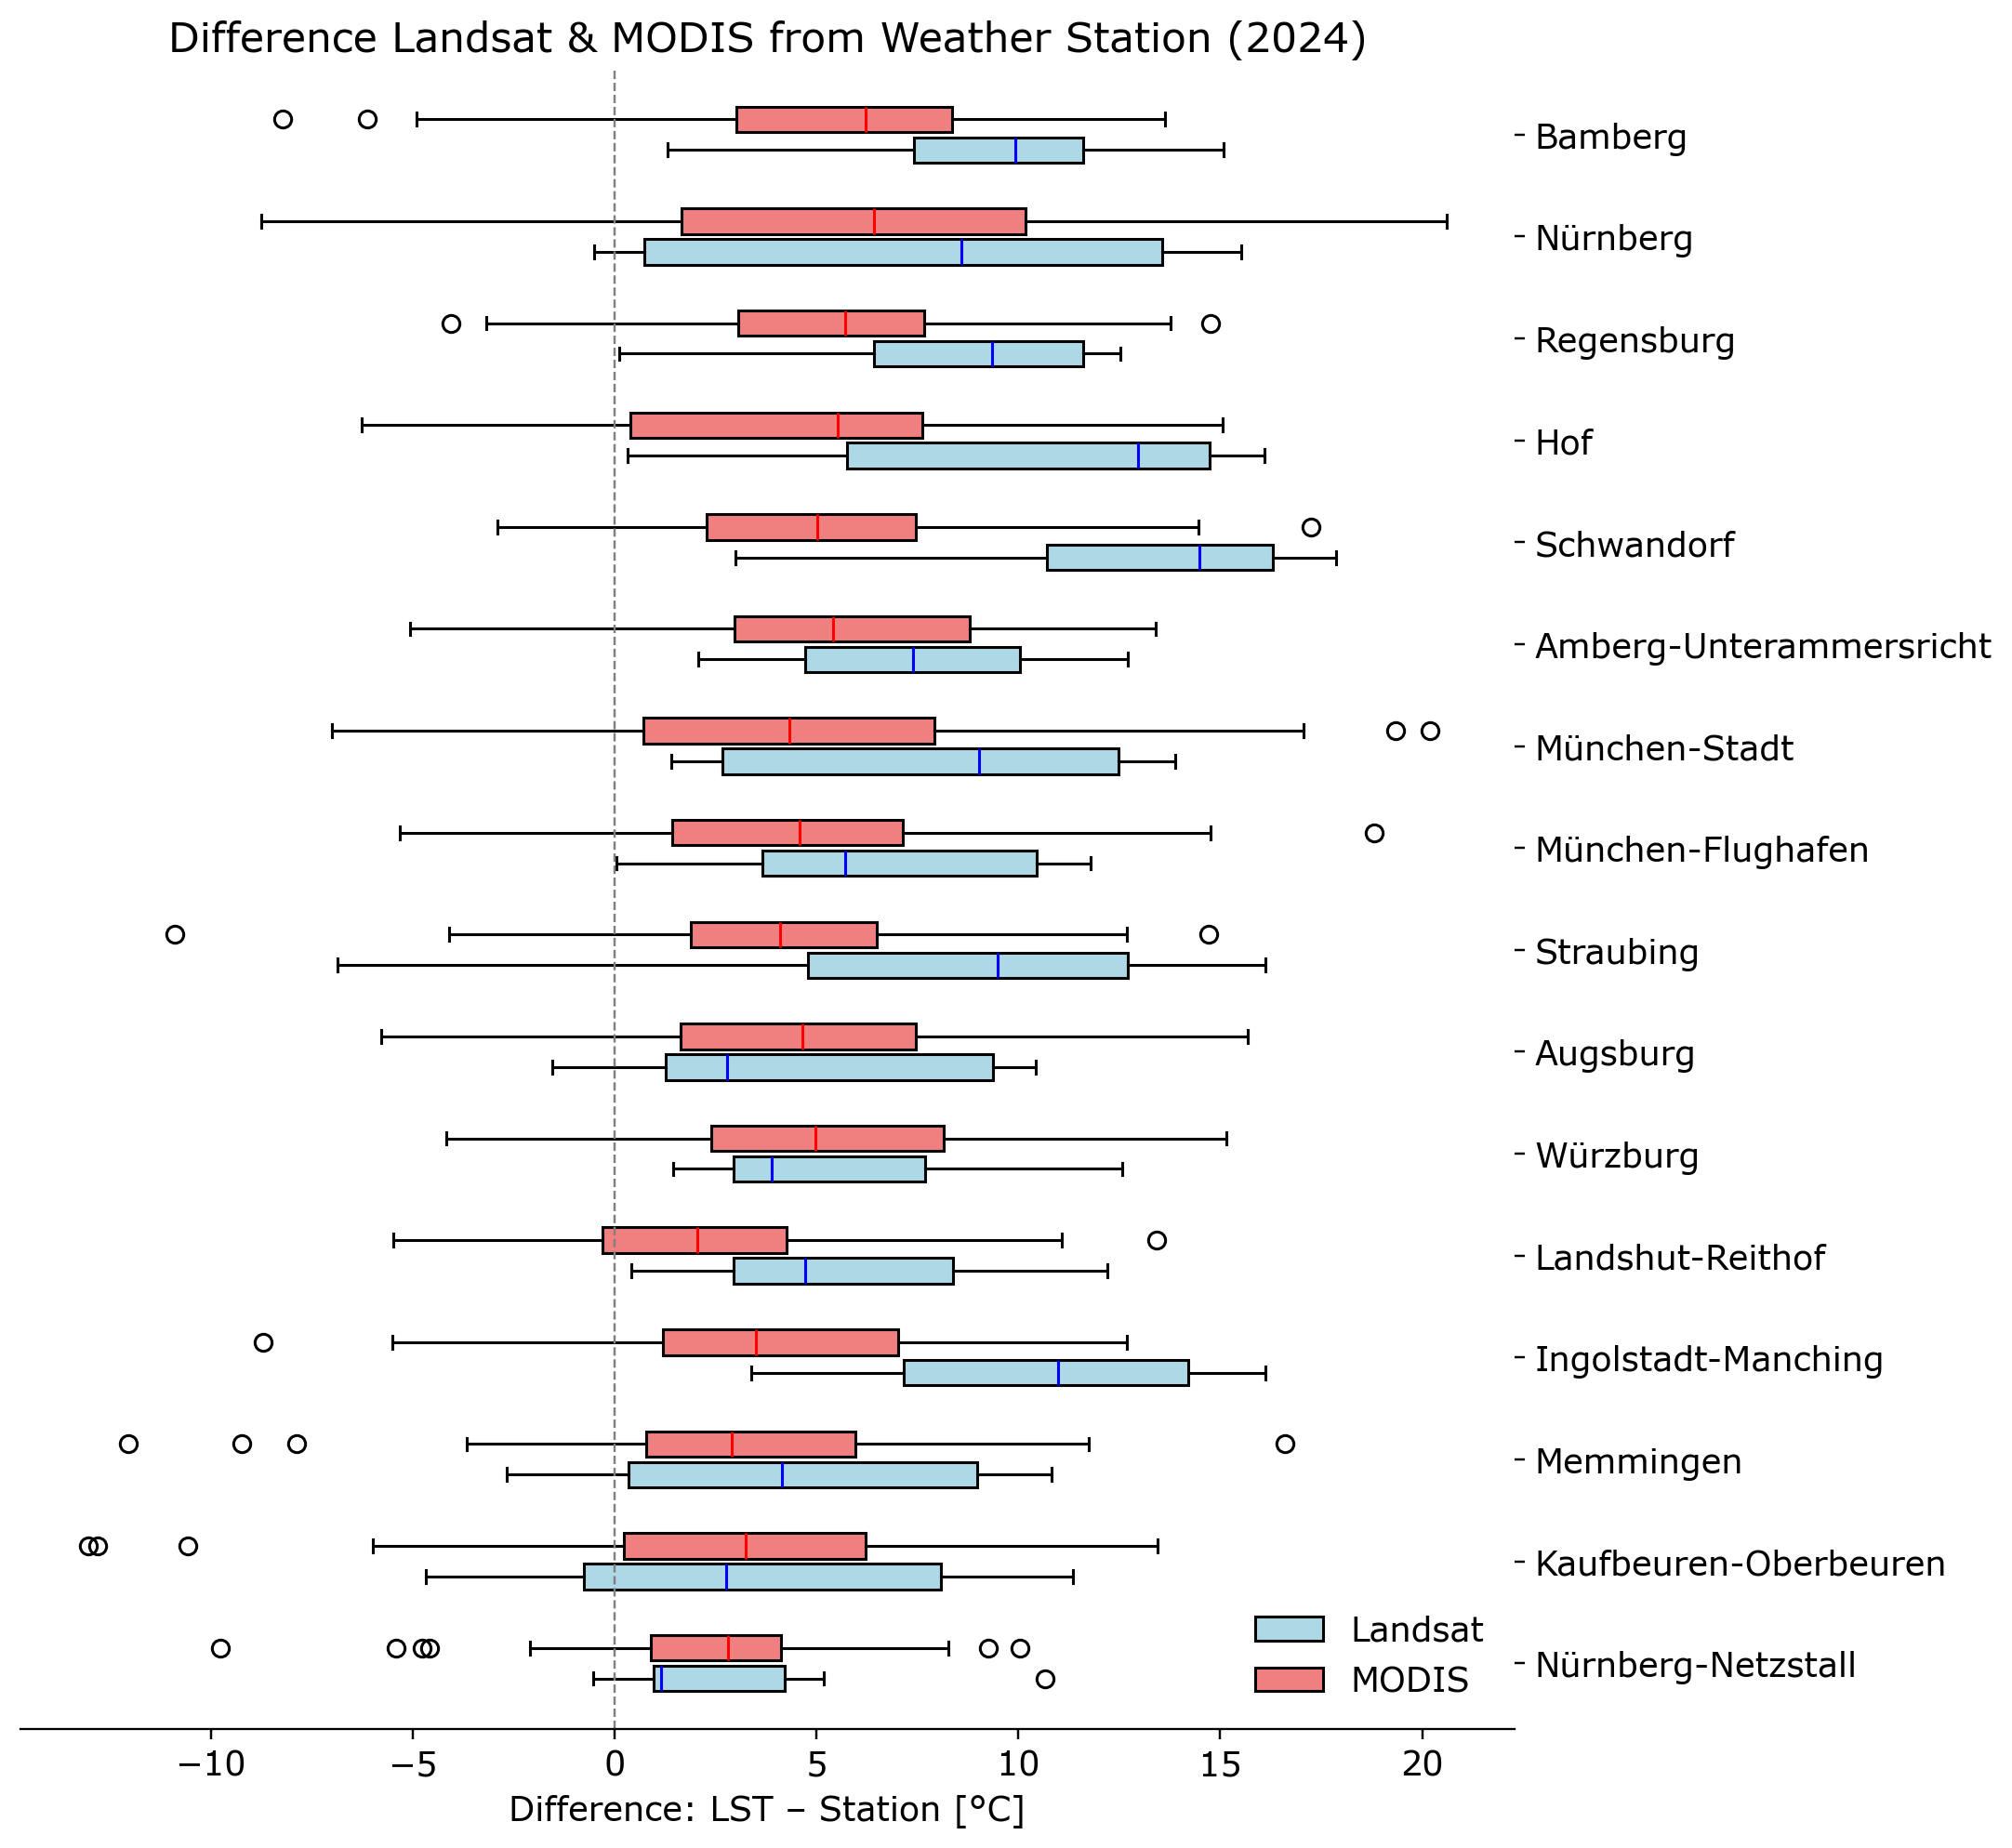

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ── KONFIGURATION ─────────────────────────────────────────────────────
CITY_COL      = "Name"   # Spalte mit Städtenamen
STATION_TEMP  = "TMK"    # Stations-Temperaturspalte
YEAR_LABEL    = "2024"   # Titel-Jahr
# ──────────────────────────────────────────────────────────────────────

# === 1 · Landsat täglich mitteln, MODIS unverändert ===
landsat_daily = (
    df_all[df_all["sensor"] == "Landsat"]
    .groupby([CITY_COL, "date"], as_index=False)
    .agg({"LST": "mean"})
    .assign(sensor="Landsat")
)
modis = df_all[df_all["sensor"] == "MODIS"][[CITY_COL, "date", "LST", "sensor"]]

lst_plot = pd.concat([landsat_daily, modis], ignore_index=True)

# === 2 · Stations-Werte anhängen und Differenz berechnen ===
df_diff = lst_plot.merge(
    stations_daily,                # enthält Spalten [Name, date, TMK]
    on=[CITY_COL, "date"],
    how="inner"
)
df_diff["diff"] = df_diff["LST"] - df_diff[STATION_TEMP]

# === 3 · Städte nach Median-Abweichung sortieren ===
order_raw = (df_diff.groupby(CITY_COL)["diff"]
                      .median()
                      .sort_values()
                      .index
                      .tolist())

# === 4 · Stadtname bereinigen (z. B. "Bamberg Bayern Frei" → "Bamberg") ===
def clean_city(name):
    return name.replace("Bayern Frei", "").strip()

order_cleaned = [clean_city(c) for c in order_raw]

# === 5 · Abweichungen je Stadt & Sensor sammeln ===
data_ls = [df_diff[
    (df_diff[CITY_COL].apply(clean_city) == c) &
    (df_diff["sensor"] == "Landsat")
]["diff"].dropna() for c in order_cleaned]

data_md = [df_diff[
    (df_diff[CITY_COL].apply(clean_city) == c) &
    (df_diff["sensor"] == "MODIS")
]["diff"].dropna() for c in order_cleaned]

# === 6 · Leere Einträge entfernen ===
order, data_ls, data_md = zip(*[
    (c, l, m) for c, l, m in zip(order_cleaned, data_ls, data_md)
    if len(l) + len(m) > 0
])

# === 7 · Plot erstellen ===
y = np.arange(len(order))
offset = 0.15

fig, ax = plt.subplots(figsize=(10, len(order)*0.45 + 2))

# Landsat
bp_ls = ax.boxplot(
    data_ls, positions=y - offset, vert=False, widths=0.25,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops=dict(color="blue")
)

# MODIS
bp_md = ax.boxplot(
    data_md, positions=y + offset, vert=False, widths=0.25,
    patch_artist=True,
    boxprops=dict(facecolor="lightcoral"),
    medianprops=dict(color="red")
)

# Achsen & Beschriftung
ax.set_yticks(y)
ax.set_yticklabels(order)

# Y-Achse nach rechts verschieben
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines["left"].set_visible(False)

ax.axvline(0, color="grey", linestyle="--", linewidth=0.8)
ax.set_xlabel("Difference: LST – Station [°C]")
ax.set_title(f"Difference Landsat & MODIS from Weather Station ({YEAR_LABEL})")

# Legende
ax.legend(
    [bp_ls["boxes"][0], bp_md["boxes"][0]],
    ["Landsat", "MODIS"],
    loc="lower right"
)

plt.tight_layout()
plt.show()


/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2008662365.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge.groupby(SENSOR_COL)


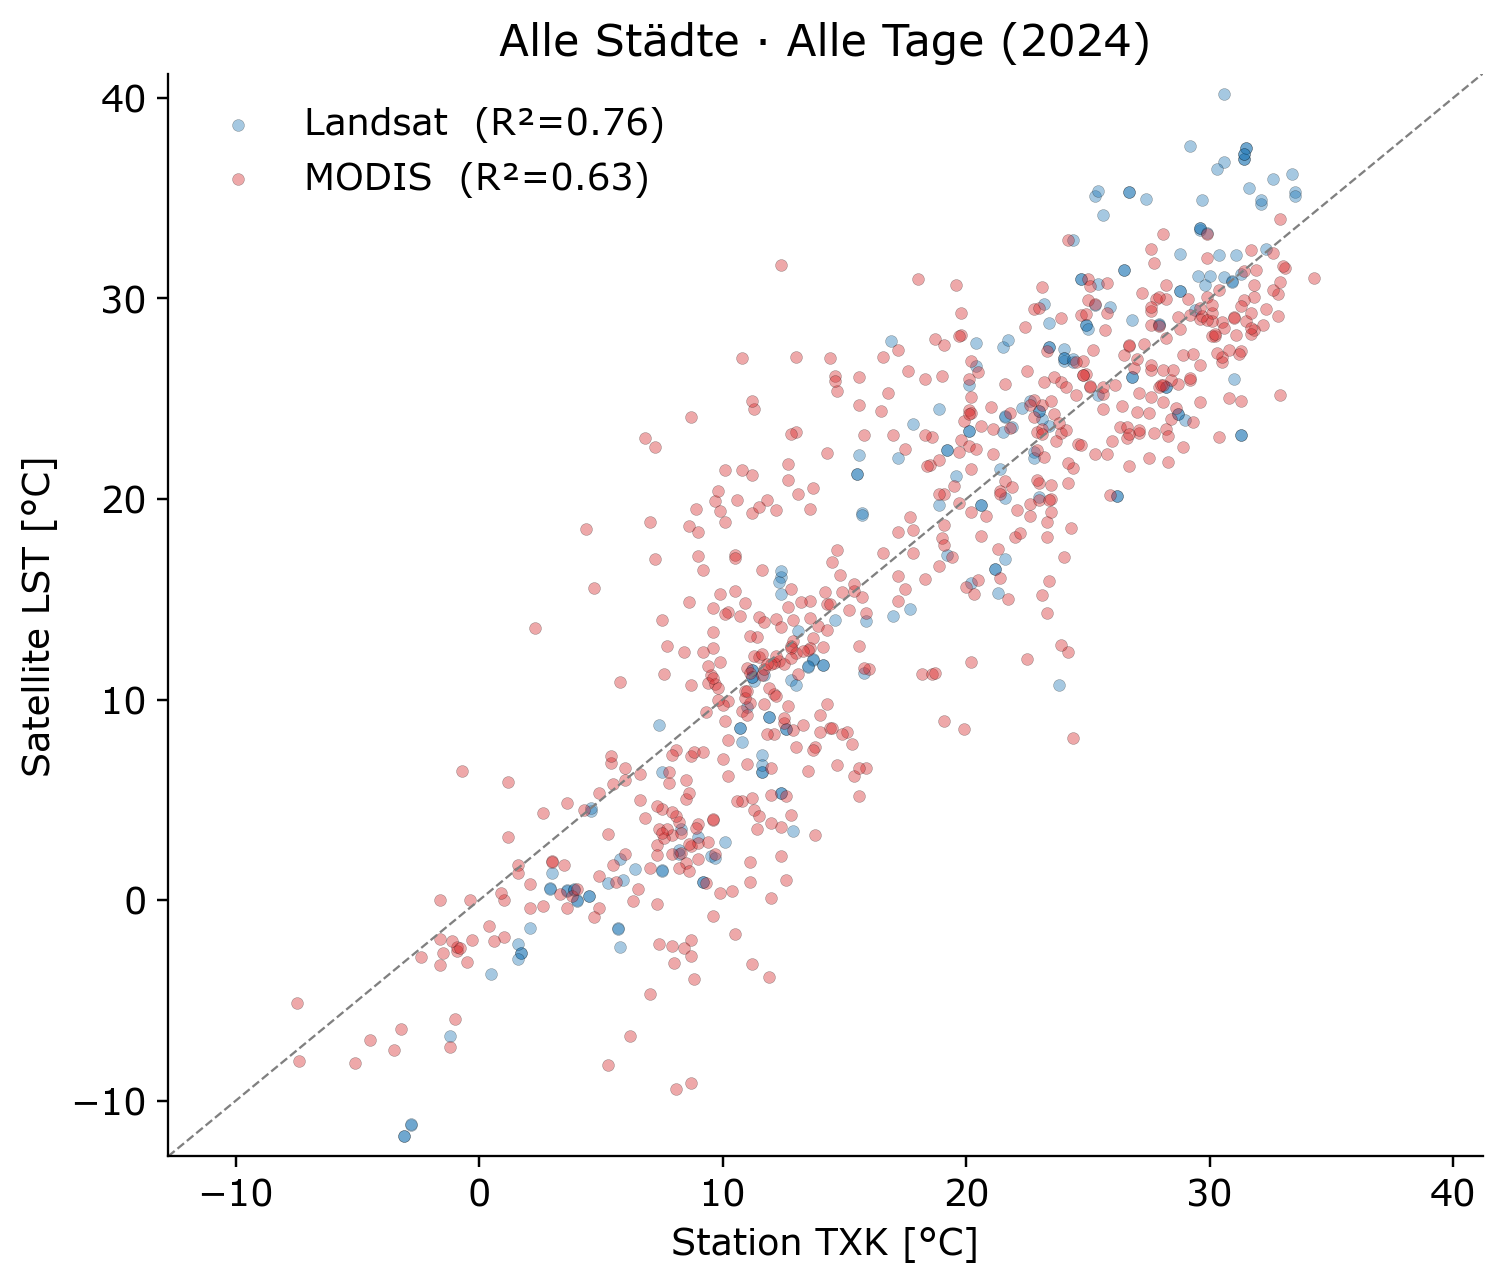

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2008662365.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub.groupby(SENSOR_COL)
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2008662365.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub.groupby(SENSOR_COL)
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2008662365.py:81: FutureWarning: DataFrameGroupBy.ap

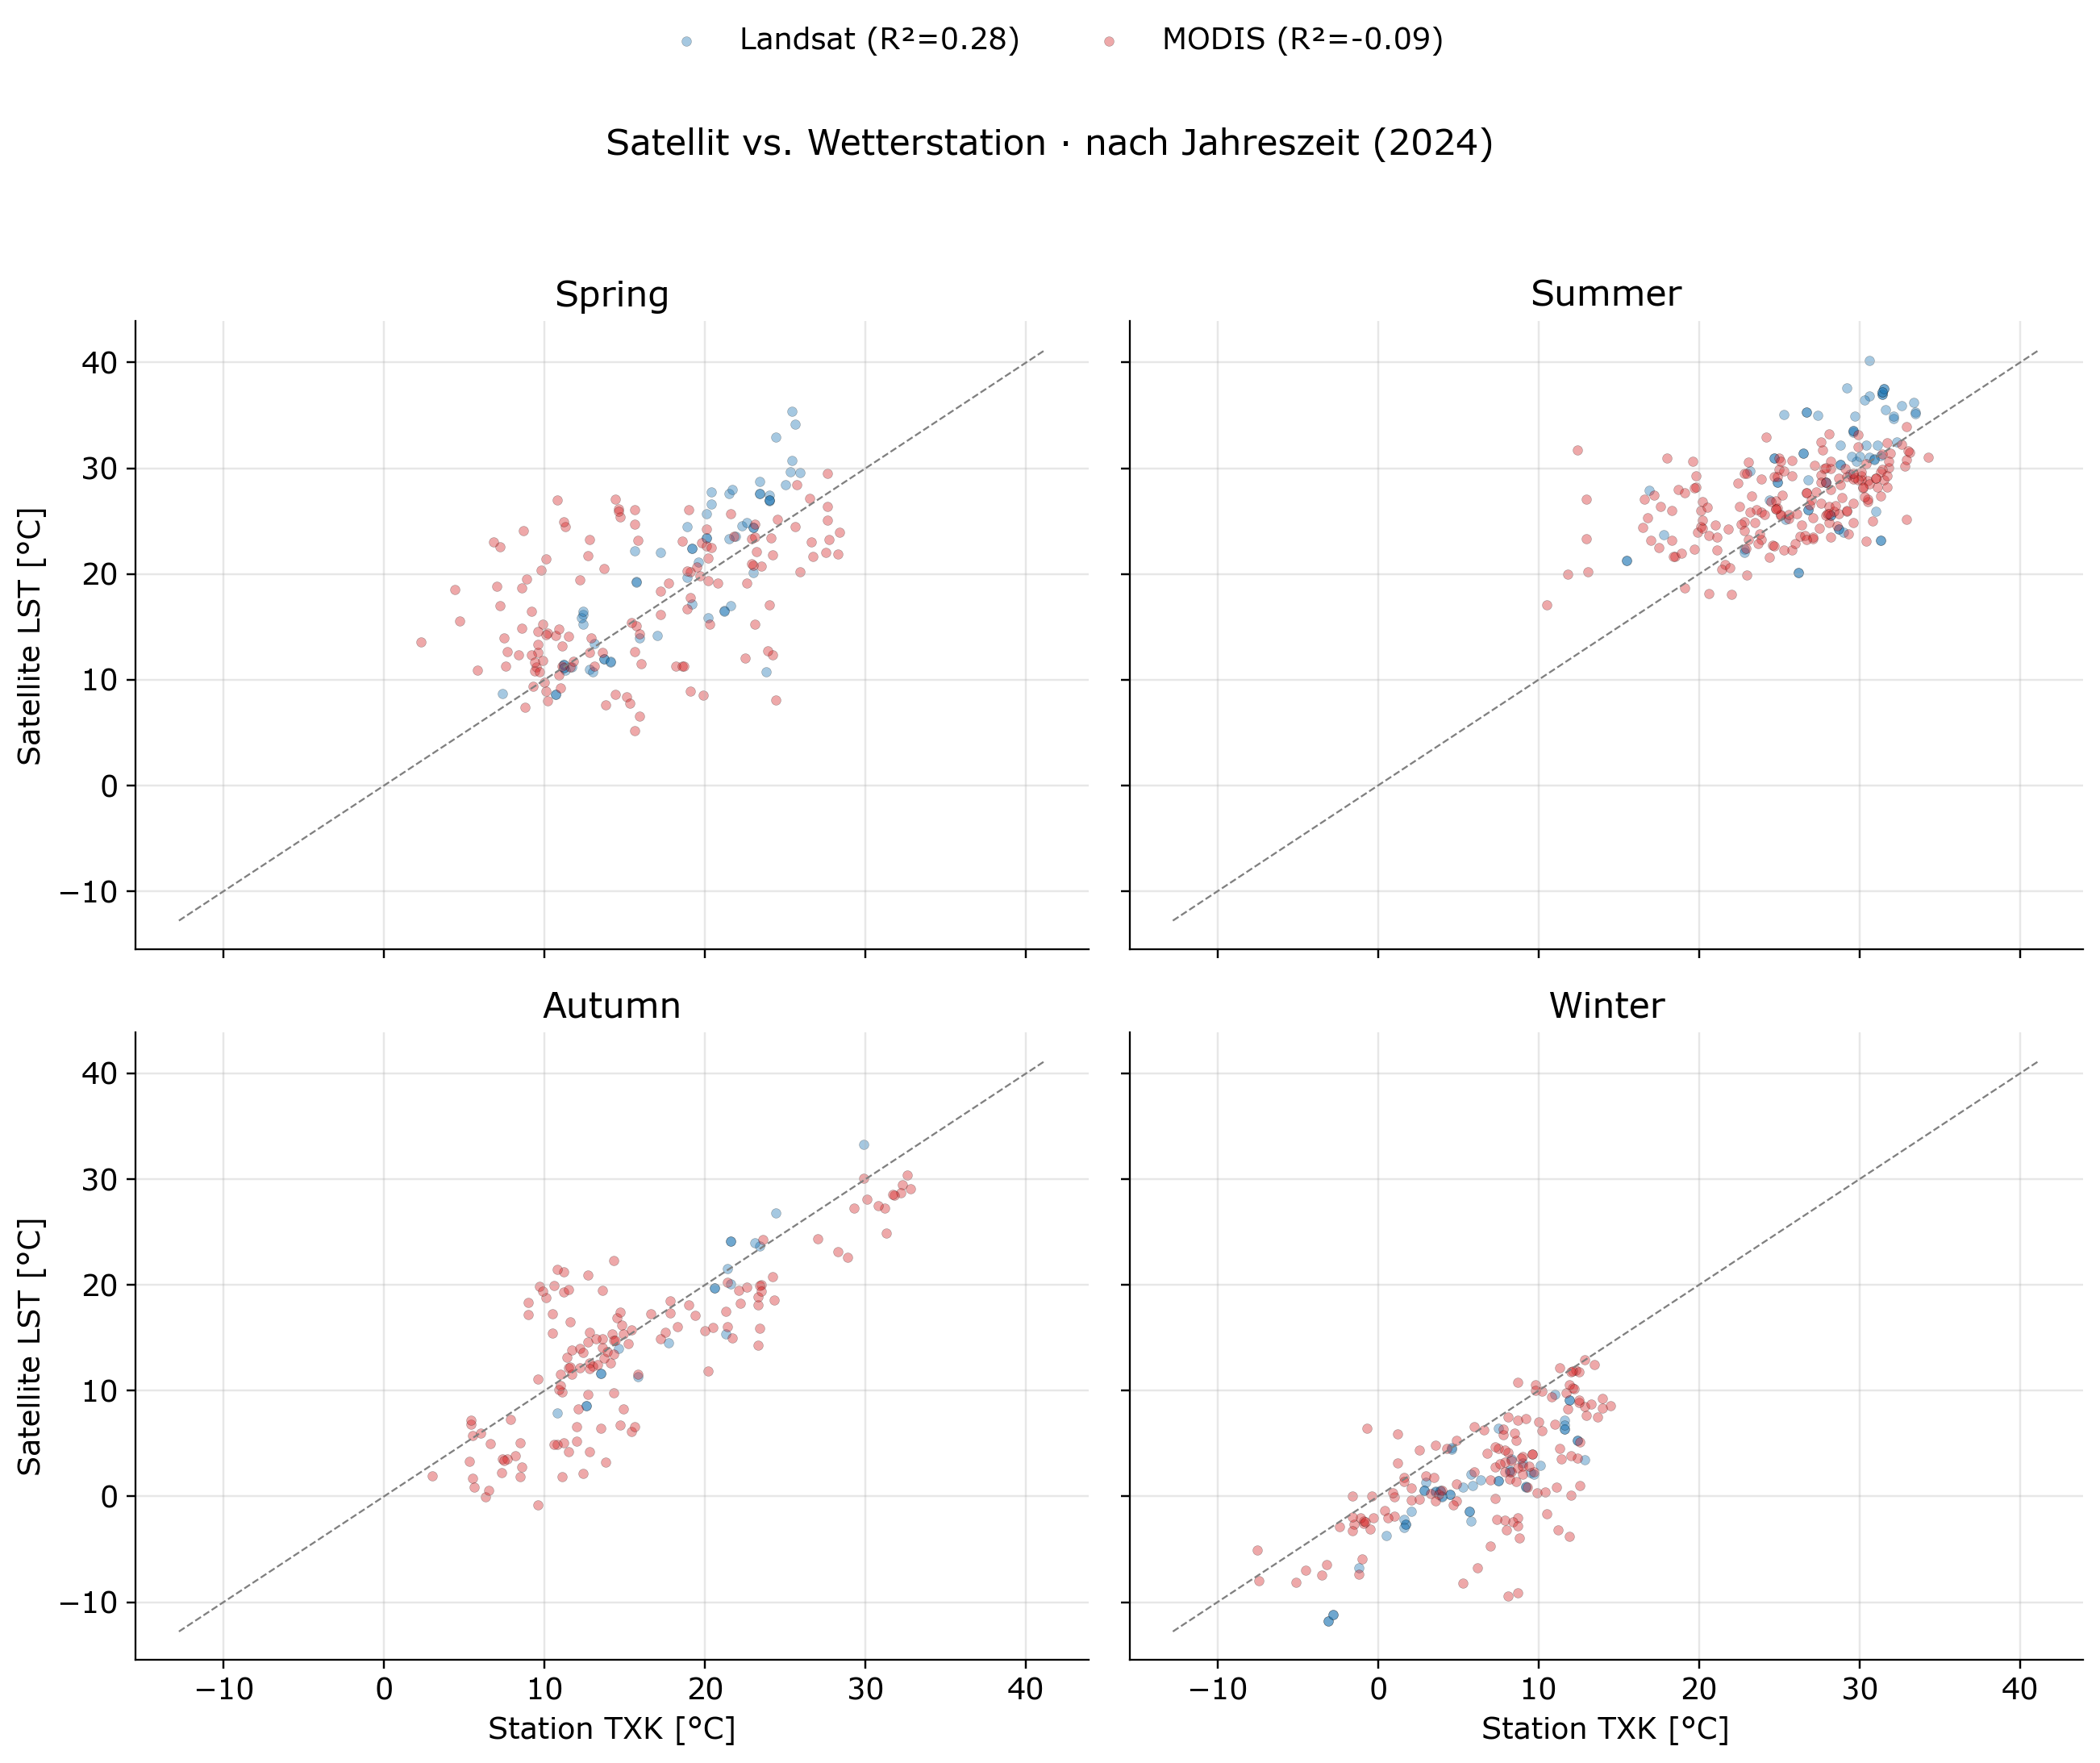

R²-Werte je Saison und Sensor:
sensor  Landsat  MODIS
season                
Autumn     0.68   0.53
Spring     0.28  -0.09
Summer    -0.53   0.16
Winter    -0.60  -0.40


/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2008662365.py:114: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge.groupby(["season", SENSOR_COL])


In [50]:
# ────────────────────────────────────────────────────────────────
# 0 · IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
# ────────────────────────────────────────────────────────────────

# 1 · BASIS-DATENFRAMES (müssen vorbereitet sein):
#    df_all        : enthält Name, date, sensor ("MODIS"/"Landsat"), LST
#    stations_daily: enthält Name, date, TXK  (Stations-Tagesmittel)
CITY_COL      = "Name"
DATE_COL      = "date"
LST_COL       = "LST"
STATION_TEMP  = "TXK"
SENSOR_COL    = "sensor"

# 2 · Merge: Satellit + Station
df_merge = (
    df_all.merge(
        stations_daily[[CITY_COL, DATE_COL, STATION_TEMP]],
        on=[CITY_COL, DATE_COL],
        how="inner"
    )
    .dropna(subset=[LST_COL, STATION_TEMP])
)

# 3 · GLOBAL: R² für jeden Sensor
r2_global = (
    df_merge.groupby(SENSOR_COL)
            .apply(lambda d: r2_score(d[STATION_TEMP], d[LST_COL]))
            .to_dict()
)

# 4 · SCATTERPLOT: alle Städte, alle Tage
fig, ax = plt.subplots(figsize=(7, 6))
colors = {"MODIS": "tab:red", "Landsat": "tab:blue"}

for sensor, d in df_merge.groupby(SENSOR_COL):
    ax.scatter(
        d[STATION_TEMP], d[LST_COL],
        s=15, alpha=0.4,
        color=colors.get(sensor, None),
        edgecolor="k", linewidth=0.15,
        label=f"{sensor}  (R²={r2_global[sensor]:.2f})"
    )

# 1:1-Linie
lims = [
    min(df_merge[STATION_TEMP].min(), df_merge[LST_COL].min()) - 1,
    max(df_merge[STATION_TEMP].max(), df_merge[LST_COL].max()) + 1,
]
ax.plot(lims, lims, linestyle="--", color="grey")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("Station TXK [°C]")
ax.set_ylabel("Satellite LST [°C]")
ax.set_title("Alle Städte · Alle Tage (2024)")
ax.legend()
plt.tight_layout()
plt.show()

# 5 · Saison-Spalte erzeugen
def season(month):
    return {12:"Winter",1:"Winter",2:"Winter",
            3:"Spring",4:"Spring",5:"Spring",
            6:"Summer",7:"Summer",8:"Summer",
            9:"Autumn",10:"Autumn",11:"Autumn"}[month]

df_merge["season"] = df_merge[DATE_COL].dt.month.map(season)

# 6 · SAISON-SCATTERPLOTS (4er-Layout)
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.ravel()

for i, seas in enumerate(["Spring", "Summer", "Autumn", "Winter"]):
    ax = axes[i]
    sub = df_merge[df_merge["season"] == seas]

    # R² für diese Saison
    r2_season = (
        sub.groupby(SENSOR_COL)
           .apply(lambda d: r2_score(d[STATION_TEMP], d[LST_COL]))
           .to_dict()
    )

    for sensor, d in sub.groupby(SENSOR_COL):
        ax.scatter(
            d[STATION_TEMP], d[LST_COL],
            s=15, alpha=0.4,
            color=colors.get(sensor, None),
            edgecolor="k", linewidth=0.15,
            label=f"{sensor} (R²={r2_season.get(sensor, np.nan):.2f})"
        )

    ax.plot(lims, lims, linestyle="--", color="grey")
    ax.set_title(seas)
    ax.grid(True, alpha=0.3)

    if i % 2 == 0:
        ax.set_ylabel("Satellite LST [°C]")
    if i >= 2:
        ax.set_xlabel("Station TXK [°C]")

# Zentrale Legende
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)

fig.suptitle("Satellit vs. Wetterstation · nach Jahreszeit (2024)", y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

# 7 · R²-TABELLE nach Saison
r2_by_season = (
    df_merge.groupby(["season", SENSOR_COL])
            .apply(lambda d: r2_score(d[STATION_TEMP], d[LST_COL]))
            .unstack()
            .round(2)
)

print("R²-Werte je Saison und Sensor:")
print(r2_by_season)


/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2860482138.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge.groupby(SENSOR_COL)


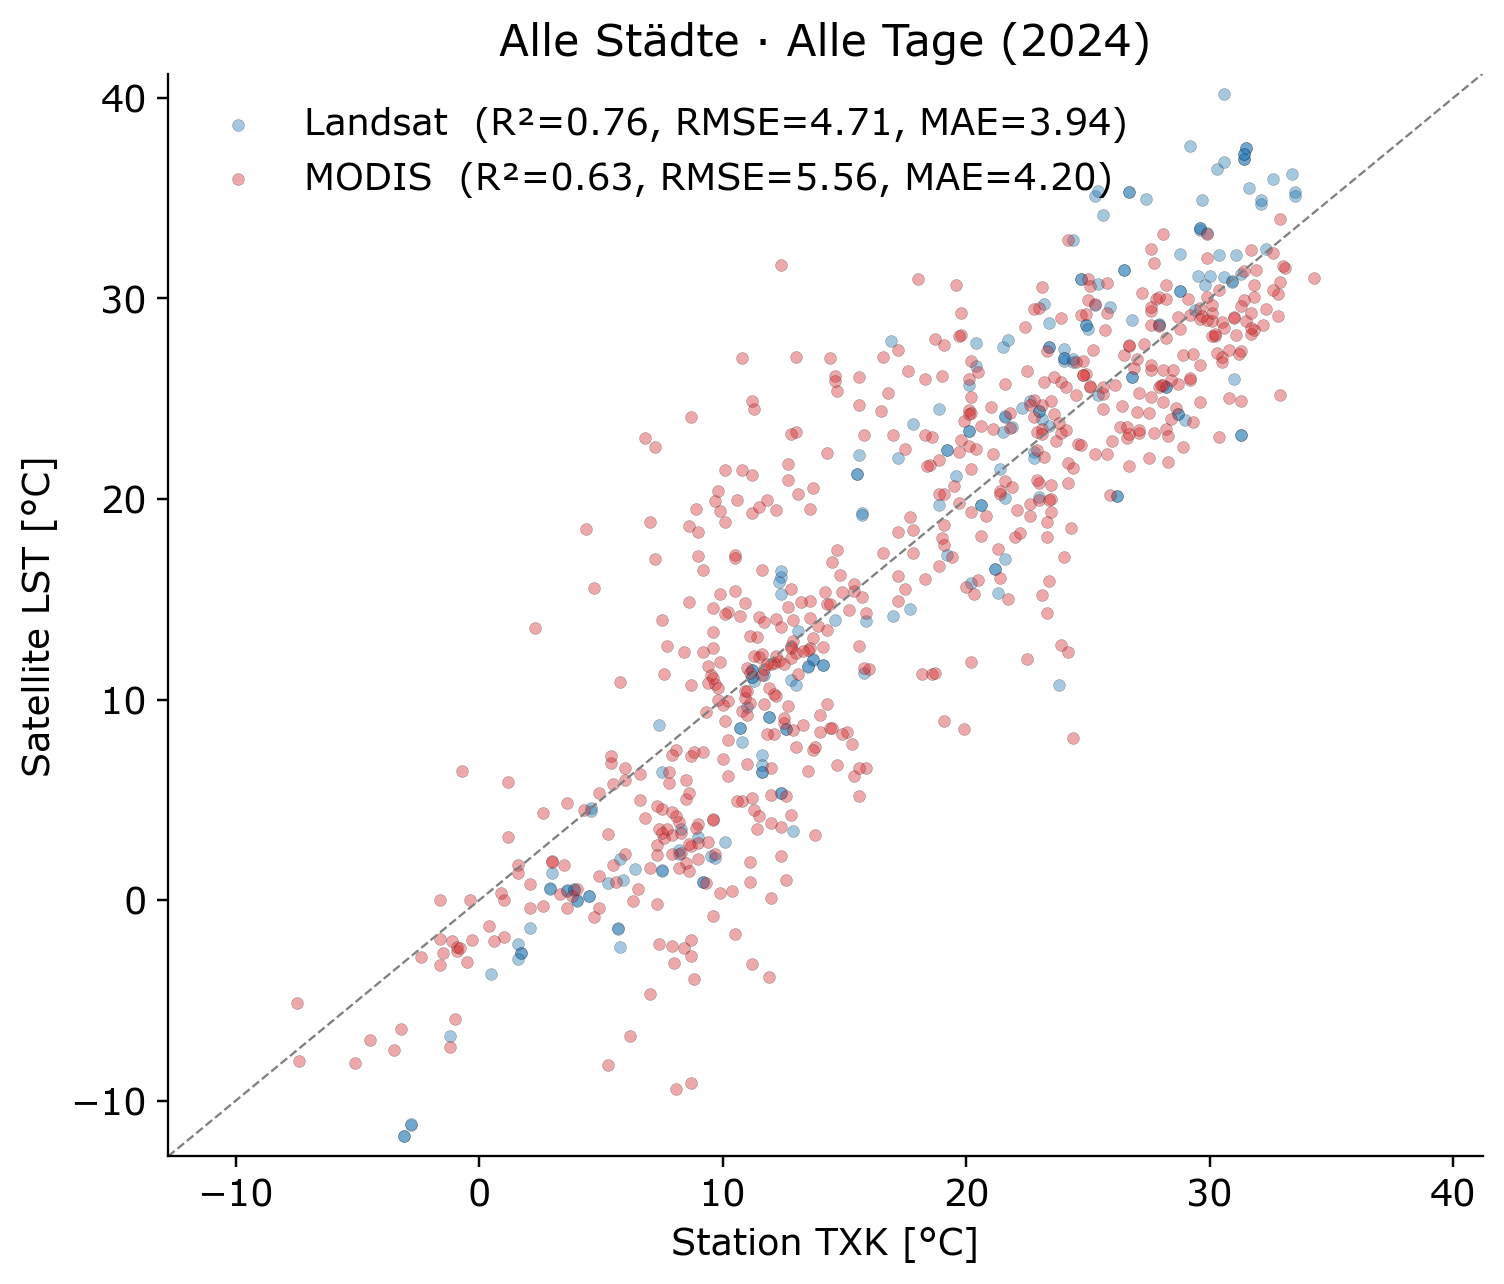

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2860482138.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub.groupby(SENSOR_COL)
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2860482138.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub.groupby(SENSOR_COL)
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2860482138.py:89: FutureWarning: DataFrameGroupBy.ap

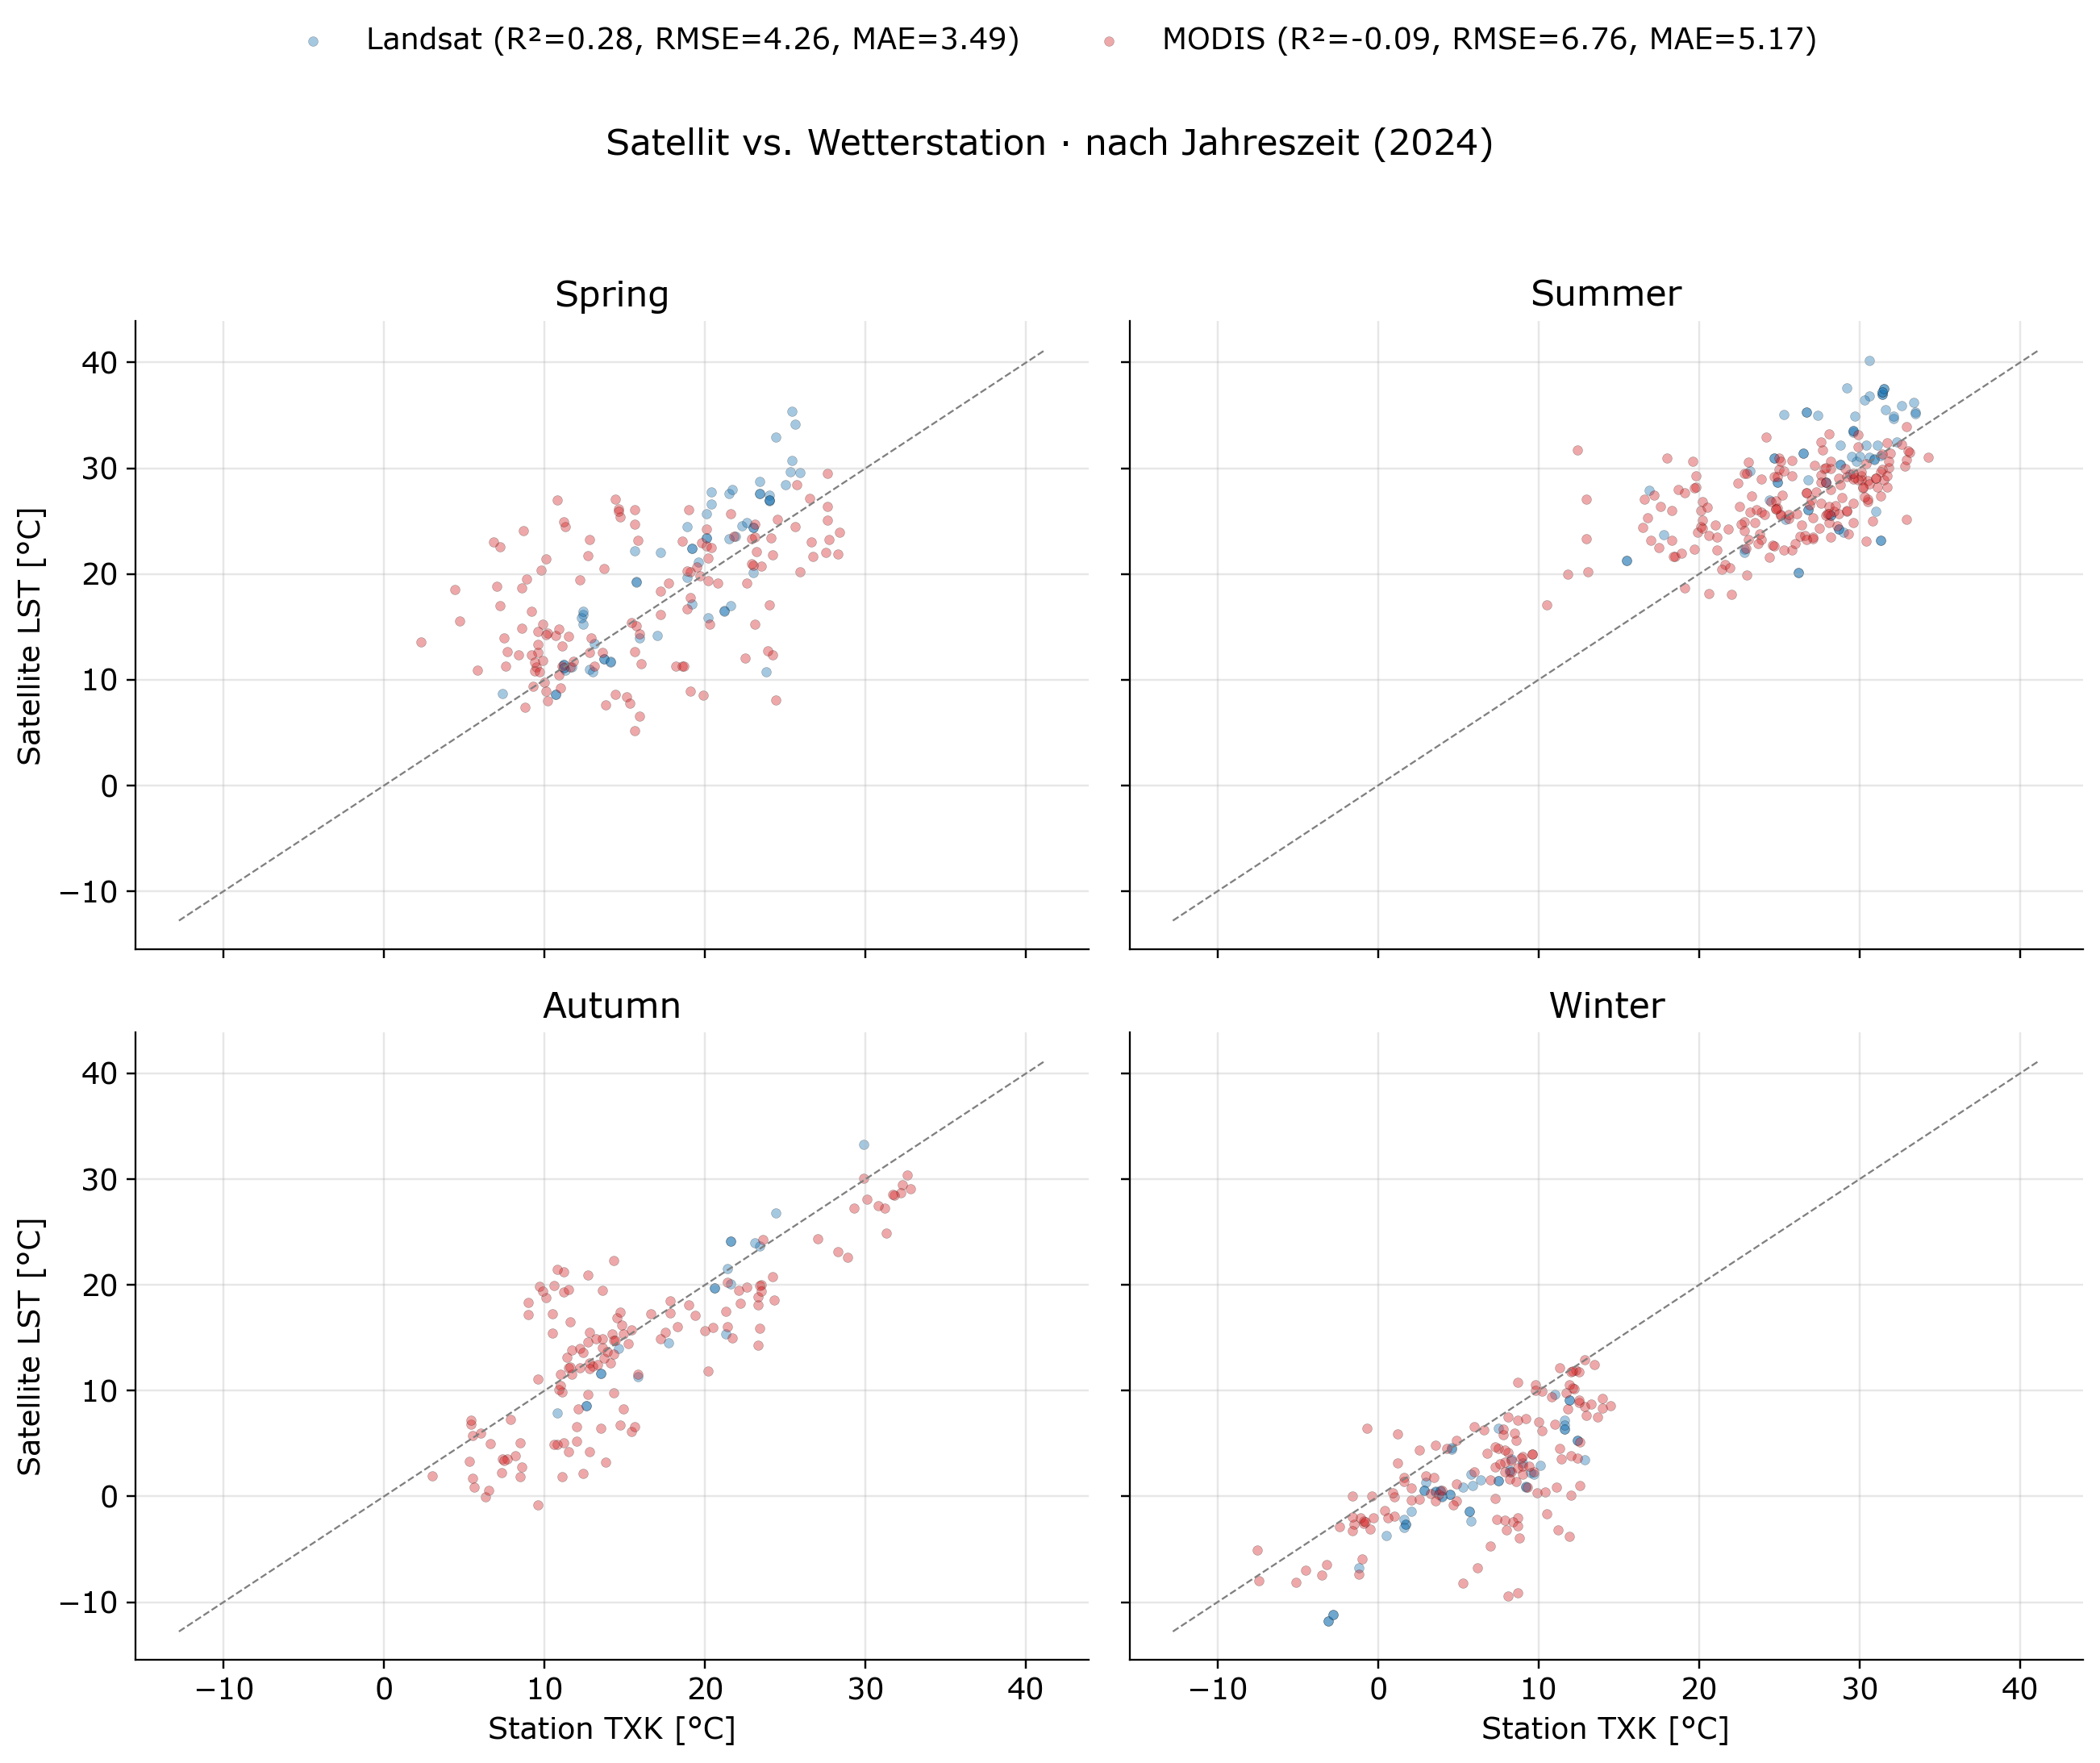

R²-Werte je Saison und Sensor:
sensor  Landsat  MODIS
season                
Autumn     0.68   0.53
Spring     0.28  -0.09
Summer    -0.53   0.16
Winter    -0.60  -0.40

RMSE-Werte je Saison und Sensor:
sensor  Landsat  MODIS
season                
Autumn     2.80   4.97
Spring     4.26   6.76
Summer     4.87   4.53
Winter     5.50   6.06

MAE-Werte je Saison und Sensor:
sensor  Landsat  MODIS
season                
Autumn     2.34   3.95
Spring     3.49   5.17
Summer     4.00   3.40
Winter     5.00   4.58


/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2860482138.py:130: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge.groupby(["season", SENSOR_COL])
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2860482138.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge.groupby(["season", SENSOR_COL])
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_8525/2860482138.py:14

In [51]:
# ────────────────────────────────────────────────────────────────
# 0 · IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# ────────────────────────────────────────────────────────────────

# 1 · BASIS-DATENFRAMES (müssen vorbereitet sein):
#    df_all        : enthält Name, date, sensor ("MODIS"/"Landsat"), LST
#    stations_daily: enthält Name, date, TXK  (Stations-Tagesmittel)
CITY_COL      = "Name"
DATE_COL      = "date"
LST_COL       = "LST"
STATION_TEMP  = "TXK"
SENSOR_COL    = "sensor"

# 2 · Merge: Satellit + Station
df_merge = (
    df_all.merge(
        stations_daily[[CITY_COL, DATE_COL, STATION_TEMP]],
        on=[CITY_COL, DATE_COL],
        how="inner"
    )
    .dropna(subset=[LST_COL, STATION_TEMP])
)

# 3 · GLOBAL: R², RMSE, MAE für jeden Sensor
metrics_global = (
    df_merge.groupby(SENSOR_COL)
            .apply(lambda d: pd.Series({
                "R2": r2_score(d[STATION_TEMP], d[LST_COL]),
                "RMSE": np.sqrt(mean_squared_error(d[STATION_TEMP], d[LST_COL])),
                "MAE": mean_absolute_error(d[STATION_TEMP], d[LST_COL])
            }))
)

r2_global = metrics_global["R2"].to_dict()
rmse_global = metrics_global["RMSE"].to_dict()
mae_global = metrics_global["MAE"].to_dict()

# 4 · SCATTERPLOT: alle Städte, alle Tage
fig, ax = plt.subplots(figsize=(7, 6))
colors = {"MODIS": "tab:red", "Landsat": "tab:blue"}

for sensor, d in df_merge.groupby(SENSOR_COL):
    ax.scatter(
        d[STATION_TEMP], d[LST_COL],
        s=15, alpha=0.4,
        color=colors.get(sensor, None),
        edgecolor="k", linewidth=0.15,
        label=(f"{sensor}  (R²={r2_global[sensor]:.2f}, "
               f"RMSE={rmse_global[sensor]:.2f}, "
               f"MAE={mae_global[sensor]:.2f})")
    )

# 1:1-Linie
lims = [
    min(df_merge[STATION_TEMP].min(), df_merge[LST_COL].min()) - 1,
    max(df_merge[STATION_TEMP].max(), df_merge[LST_COL].max()) + 1,
]
ax.plot(lims, lims, linestyle="--", color="grey")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("Station TXK [°C]")
ax.set_ylabel("Satellite LST [°C]")
ax.set_title("Alle Städte · Alle Tage (2024)")
ax.legend()
plt.tight_layout()
plt.show()

# 5 · Saison-Spalte erzeugen
def season(month):
    return {12:"Winter",1:"Winter",2:"Winter",
            3:"Spring",4:"Spring",5:"Spring",
            6:"Summer",7:"Summer",8:"Summer",
            9:"Autumn",10:"Autumn",11:"Autumn"}[month]

df_merge["season"] = df_merge[DATE_COL].dt.month.map(season)

# 6 · SAISON-SCATTERPLOTS (4er-Layout)
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.ravel()

for i, seas in enumerate(["Spring", "Summer", "Autumn", "Winter"]):
    ax = axes[i]
    sub = df_merge[df_merge["season"] == seas]

    metrics_season = (
        sub.groupby(SENSOR_COL)
           .apply(lambda d: pd.Series({
               "R2": r2_score(d[STATION_TEMP], d[LST_COL]),
               "RMSE": np.sqrt(mean_squared_error(d[STATION_TEMP], d[LST_COL])),
               "MAE": mean_absolute_error(d[STATION_TEMP], d[LST_COL])
           }))
    )
    r2_season = metrics_season["R2"].to_dict()
    rmse_season = metrics_season["RMSE"].to_dict()
    mae_season = metrics_season["MAE"].to_dict()

    for sensor, d in sub.groupby(SENSOR_COL):
        ax.scatter(
            d[STATION_TEMP], d[LST_COL],
            s=15, alpha=0.4,
            color=colors.get(sensor, None),
            edgecolor="k", linewidth=0.15,
            label=(f"{sensor} (R²={r2_season.get(sensor, np.nan):.2f}, "
                   f"RMSE={rmse_season.get(sensor, np.nan):.2f}, "
                   f"MAE={mae_season.get(sensor, np.nan):.2f})")
        )

    ax.plot(lims, lims, linestyle="--", color="grey")
    ax.set_title(seas)
    ax.grid(True, alpha=0.3)

    if i % 2 == 0:
        ax.set_ylabel("Satellite LST [°C]")
    if i >= 2:
        ax.set_xlabel("Station TXK [°C]")

# Zentrale Legende
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)

fig.suptitle("Satellit vs. Wetterstation · nach Jahreszeit (2024)", y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

# 7 · R², RMSE, MAE-TABELLE nach Saison
r2_by_season = (
    df_merge.groupby(["season", SENSOR_COL])
            .apply(lambda d: r2_score(d[STATION_TEMP], d[LST_COL]))
            .unstack()
            .round(2)
)

rmse_by_season = (
    df_merge.groupby(["season", SENSOR_COL])
            .apply(lambda d: np.sqrt(mean_squared_error(d[STATION_TEMP], d[LST_COL])))
            .unstack()
            .round(2)
)

mae_by_season = (
    df_merge.groupby(["season", SENSOR_COL])
            .apply(lambda d: mean_absolute_error(d[STATION_TEMP], d[LST_COL]))
            .unstack()
            .round(2)
)

print("R²-Werte je Saison und Sensor:")
print(r2_by_season)
print("\nRMSE-Werte je Saison und Sensor:")
print(rmse_by_season)
print("\nMAE-Werte je Saison und Sensor:")
print(mae_by_season)


In [52]:
df_merge.to_csv('Input/city_metrics.csv')